<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
import seaborn as sns


%matplotlib inline

In [2]:
!nvidia-smi

Thu Dec  7 11:58:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [5]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_photos, val_photos = train_test_split(torch.FloatTensor(data), train_size=0.9, shuffle=False)

In [8]:
print(f"Train dataset: {train_photos.shape}")
print(f"Validation dataset: {val_photos.shape}")

Train dataset: torch.Size([11828, 64, 64, 3])
Validation dataset: torch.Size([1315, 64, 64, 3])


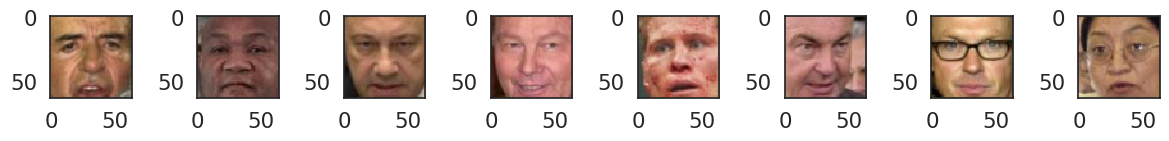

In [9]:
sns.set(style='white', font_scale=1.4)

plt.figure(figsize=(12, 12))
plt.tight_layout()
for i, j in enumerate(np.random.choice(len(train_photos), size=8)):
    plt.subplot(1, 8, i + 1)
    image = train_photos[j]
    skimage.io.imshow(image.numpy())

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

### Convolutional Autoencoder

In [10]:
from copy import deepcopy
import torch.nn.functional as F

class ConvolutionalAutoencoder(nn.Module):
    class Encoder(nn.Module):
        def __init__(self, dim_code, encoder_activation):
            super().__init__()
            self.dim_code = dim_code

            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
            self.fc = nn.Linear(16 * 64**2, self.dim_code**2)
            self.encoder_activation = encoder_activation

        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = self.conv2(x)
            x = torch.flatten(x, start_dim=1)
            x = self.fc(x)
            if self.encoder_activation:
                x = F.relu(x)
            return x


    class Decoder(nn.Module):
        def __init__(self, dim_code):
            super().__init__()
            self.dim_code = dim_code

            self.fc = nn.Linear(self.dim_code**2, 16 * 64**2)
            self.deconv1 = nn.ConvTranspose2d(16, 32, kernel_size=3, padding=1)
            self.deconv2 = nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1)

        def forward(self, x):
            x = F.relu(self.fc(x))
            x = torch.reshape(x, (x.shape[0], 16, 64, 64))
            x = F.relu(self.deconv1(x))
            x = self.deconv2(x)
            return x

    def __init__(self, dim_code, encoder_activation=True):
        super().__init__()
        self.dim_code = dim_code

        self.encoder = self.Encoder(dim_code, encoder_activation)
        self.decoder = self.Decoder(dim_code)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)

        return torch.sigmoid(reconstructed)

### Linear Autoencoder

In [11]:
class LinearAutoencoder(nn.Module):
    class Encoder(nn.Module):
        def __init__(self, dim_code):
            super().__init__()
            self.dim_code = dim_code
            self.encode = nn.Sequential(
                nn.Linear(3 * 64**2, 2048),
                nn.ReLU(),
                nn.Linear(2048, self.dim_code**2)
            )

        def forward(self, x):
            x = x.reshape(x.shape[0], 3 * 64**2)
            return self.encode(x)

    class Decoder(nn.Module):
        def __init__(self, dim_code):
            super().__init__()
            self.dim_code = dim_code
            self.decode = nn.Sequential(
                nn.Linear(self.dim_code**2, 2048),
                nn.ReLU(),
                nn.Linear(2048, 3 * 64**2)
            )

        def forward(self, x):
            x = self.decode(x)
            x = x.reshape(x.shape[0], 3, 64, 64)
            return x

    def __init__(self, dim_code):
        super().__init__()
        self.encoder = self.Encoder(dim_code)
        self.decoder = self.Decoder(dim_code)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.sigmoid(x)


## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [12]:
def fit_epoch_1(model, data_loader, optimizer, criterion):
    model.train()

    running_loss = 0.0
    processed_size = 0

    for batch in data_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        reconstruction = model(batch)
        loss = criterion(reconstruction, batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        processed_size += len(batch)

    return running_loss / processed_size

In [13]:
from IPython.display import clear_output

In [14]:
def eval_epoch_1(model, data_loader, criterion):
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        processed_size = 0

        for batch in data_loader:
            batch = batch.to(device)
            reconstruction = model(batch)
            loss = criterion(reconstruction, batch)
            running_loss += loss.item()
            processed_size += len(batch)

    return running_loss / processed_size

In [15]:
from tqdm import tqdm
from time import time

def train_1(model, tr_loader, val_loader, optimizer, criterion, epochs):
    history = []
    train_time = 0

    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            tic = time()
            train_loss = fit_epoch_1(model, tr_loader, optimizer, criterion)
            toc = time()
            train_time += toc - tic
            print(f"Train loss: {train_loss}")
            val_loss = eval_epoch_1(model, val_loader, criterion)
            history.append((train_loss, val_loss, train_time))
            print(f"Train loss: {train_loss}, val loss: {val_loss}")
            pbar.update(1)
    return history

In [16]:
train_loader = torch.utils.data.DataLoader(torch.permute(train_photos, (0, 3, 1, 2)), batch_size=8)
val_loader = torch.utils.data.DataLoader(torch.permute(val_photos, (0, 3, 1, 2)), batch_size=8)

In [17]:
criterion = nn.BCELoss(reduction='sum')

dim_code_list =  [4, 16, 24]
autoencoders = {
    'conv': [],
    'linear': []
}
history = {
    'conv': [],
    'linear': []
}

In [18]:
for dim_code in dim_code_list:
    print("Dim code: ", dim_code)
    conv_model = ConvolutionalAutoencoder(dim_code, encoder_activation=True).to(device)
    autoencoders['conv'].append(conv_model)
    optimizer = torch.optim.AdamW(conv_model.parameters(), lr=0.0001)
    hist = train_1(conv_model, train_loader, val_loader, optimizer, criterion, 25)
    history['conv'].append(hist)

    linear_model = LinearAutoencoder(dim_code).to(device)
    autoencoders['linear'].append(linear_model)
    optimizer = torch.optim.AdamW(linear_model.parameters(), lr=0.0001)
    hist = train_1(linear_model, train_loader, val_loader, optimizer, criterion, 25)
    history['linear'].append(hist)

Dim code:  4


  0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 7882.845970961384


  4%|▍         | 1/25 [00:13<05:33, 13.89s/it]

Train loss: 7882.845970961384, val loss: 7666.1061519724335
Train loss: 7644.864229740869


  8%|▊         | 2/25 [00:20<03:37,  9.46s/it]

Train loss: 7644.864229740869, val loss: 7631.483668013308
Train loss: 7627.675507469035


 12%|█▏        | 3/25 [00:26<02:57,  8.07s/it]

Train loss: 7627.675507469035, val loss: 7622.121383376902
Train loss: 7621.053205978399


 16%|█▌        | 4/25 [00:32<02:34,  7.37s/it]

Train loss: 7621.053205978399, val loss: 7617.436363771388
Train loss: 7617.2569581316575


 20%|██        | 5/25 [00:39<02:21,  7.08s/it]

Train loss: 7617.2569581316575, val loss: 7616.084155180608
Train loss: 7615.119589110585


 24%|██▍       | 6/25 [00:45<02:09,  6.80s/it]

Train loss: 7615.119589110585, val loss: 7610.030883139259
Train loss: 7613.509918863079


 28%|██▊       | 7/25 [00:52<02:01,  6.74s/it]

Train loss: 7613.509918863079, val loss: 7608.597136406844
Train loss: 7612.009657136403


 32%|███▏      | 8/25 [00:58<01:52,  6.59s/it]

Train loss: 7612.009657136403, val loss: 7609.613129752852
Train loss: 7610.695212928274


 36%|███▌      | 9/25 [01:05<01:45,  6.61s/it]

Train loss: 7610.695212928274, val loss: 7609.617728136882
Train loss: 7609.687183781334


 40%|████      | 10/25 [01:11<01:37,  6.51s/it]

Train loss: 7609.687183781334, val loss: 7607.598355810361
Train loss: 7608.678823058896


 44%|████▍     | 11/25 [01:18<01:31,  6.55s/it]

Train loss: 7608.678823058896, val loss: 7606.778821589829
Train loss: 7607.75396965886


 48%|████▊     | 12/25 [01:24<01:24,  6.49s/it]

Train loss: 7607.75396965886, val loss: 7605.54816272576
Train loss: 7607.205262407


 52%|█████▏    | 13/25 [01:31<01:18,  6.55s/it]

Train loss: 7607.205262407, val loss: 7603.303511169202
Train loss: 7606.665029154866


 56%|█████▌    | 14/25 [01:37<01:11,  6.50s/it]

Train loss: 7606.665029154866, val loss: 7602.598648407795
Train loss: 7605.9202060589805


 60%|██████    | 15/25 [01:44<01:05,  6.57s/it]

Train loss: 7605.9202060589805, val loss: 7602.298116682509
Train loss: 7605.2678869129395


 64%|██████▍   | 16/25 [01:50<00:58,  6.51s/it]

Train loss: 7605.2678869129395, val loss: 7601.879838997148
Train loss: 7604.657504967027


 68%|██████▊   | 17/25 [01:57<00:52,  6.56s/it]

Train loss: 7604.657504967027, val loss: 7601.478733959126
Train loss: 7604.338545024254


 72%|███████▏  | 18/25 [02:03<00:45,  6.49s/it]

Train loss: 7604.338545024254, val loss: 7601.969510456273
Train loss: 7604.502524630379


 76%|███████▌  | 19/25 [02:10<00:39,  6.53s/it]

Train loss: 7604.502524630379, val loss: 7603.134847314639
Train loss: 7603.955120397573


 80%|████████  | 20/25 [02:16<00:32,  6.48s/it]

Train loss: 7603.955120397573, val loss: 7600.791351295152
Train loss: 7603.0353644754505


 84%|████████▍ | 21/25 [02:23<00:25,  6.50s/it]

Train loss: 7603.0353644754505, val loss: 7600.375959481939
Train loss: 7602.118914235553


 88%|████████▊ | 22/25 [02:29<00:19,  6.48s/it]

Train loss: 7602.118914235553, val loss: 7599.950487167301
Train loss: 7601.226792852501


 92%|█████████▏| 23/25 [02:36<00:12,  6.49s/it]

Train loss: 7601.226792852501, val loss: 7600.176310004753
Train loss: 7600.700123812405


 96%|█████████▌| 24/25 [02:42<00:06,  6.49s/it]

Train loss: 7600.700123812405, val loss: 7600.530791052756
Train loss: 7600.324325917579


100%|██████████| 25/25 [02:49<00:00,  6.77s/it]

Train loss: 7600.324325917579, val loss: 7602.4551627851715



  0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 7727.421483318186


  4%|▍         | 1/25 [00:30<12:15, 30.63s/it]

Train loss: 7727.421483318186, val loss: 7596.53553944867
Train loss: 7557.394303374408


  8%|▊         | 2/25 [01:01<11:44, 30.61s/it]

Train loss: 7557.394303374408, val loss: 7522.752036299905
Train loss: 7516.8811949135525


 12%|█▏        | 3/25 [01:31<11:13, 30.62s/it]

Train loss: 7516.8811949135525, val loss: 7502.843610384981
Train loss: 7505.364732057935


 16%|█▌        | 4/25 [02:02<10:43, 30.62s/it]

Train loss: 7505.364732057935, val loss: 7497.768420270912
Train loss: 7500.142528586828


 20%|██        | 5/25 [02:33<10:12, 30.63s/it]

Train loss: 7500.142528586828, val loss: 7495.584339353612
Train loss: 7496.599302238333


 24%|██▍       | 6/25 [03:03<09:41, 30.62s/it]

Train loss: 7496.599302238333, val loss: 7493.217996970057
Train loss: 7493.961904154866


 28%|██▊       | 7/25 [03:34<09:10, 30.61s/it]

Train loss: 7493.961904154866, val loss: 7493.441211680133
Train loss: 7491.540061850059


 32%|███▏      | 8/25 [04:04<08:40, 30.61s/it]

Train loss: 7491.540061850059, val loss: 7492.245373395913
Train loss: 7489.712372785974


 36%|███▌      | 9/25 [04:35<08:09, 30.62s/it]

Train loss: 7489.712372785974, val loss: 7492.451047112642
Train loss: 7488.017992594374


 40%|████      | 10/25 [05:06<07:39, 30.61s/it]

Train loss: 7488.017992594374, val loss: 7491.84844938213
Train loss: 7486.712072419524


 44%|████▍     | 11/25 [05:36<07:08, 30.61s/it]

Train loss: 7486.712072419524, val loss: 7490.543322243346
Train loss: 7485.32525756547


 48%|████▊     | 12/25 [06:07<06:37, 30.60s/it]

Train loss: 7485.32525756547, val loss: 7489.150311905893
Train loss: 7484.062069348157


 52%|█████▏    | 13/25 [06:38<06:07, 30.62s/it]

Train loss: 7484.062069348157, val loss: 7488.035578065589
Train loss: 7482.8185060079895


 56%|█████▌    | 14/25 [07:08<05:36, 30.62s/it]

Train loss: 7482.8185060079895, val loss: 7486.958688807034
Train loss: 7481.467761878594


 60%|██████    | 15/25 [07:39<05:06, 30.61s/it]

Train loss: 7481.467761878594, val loss: 7486.506985206749
Train loss: 7480.415118323575


 64%|██████▍   | 16/25 [08:09<04:35, 30.61s/it]

Train loss: 7480.415118323575, val loss: 7486.948737523764
Train loss: 7479.367982917917


 68%|██████▊   | 17/25 [08:40<04:04, 30.62s/it]

Train loss: 7479.367982917917, val loss: 7486.909235384981
Train loss: 7478.586380371259


 72%|███████▏  | 18/25 [09:11<03:34, 30.63s/it]

Train loss: 7478.586380371259, val loss: 7486.914251128802
Train loss: 7477.724262112413


 76%|███████▌  | 19/25 [09:41<03:03, 30.62s/it]

Train loss: 7477.724262112413, val loss: 7486.683072421578
Train loss: 7476.681545016328


 80%|████████  | 20/25 [10:12<02:33, 30.62s/it]

Train loss: 7476.681545016328, val loss: 7486.210979087453
Train loss: 7475.71830415645


 84%|████████▍ | 21/25 [10:43<02:02, 30.63s/it]

Train loss: 7475.71830415645, val loss: 7486.317633079848
Train loss: 7474.791499282687


 88%|████████▊ | 22/25 [11:13<01:31, 30.64s/it]

Train loss: 7474.791499282687, val loss: 7484.996763605038
Train loss: 7473.886982953584


 92%|█████████▏| 23/25 [11:44<01:01, 30.63s/it]

Train loss: 7473.886982953584, val loss: 7484.900885218632
Train loss: 7473.114432186866


 96%|█████████▌| 24/25 [12:14<00:30, 30.63s/it]

Train loss: 7473.114432186866, val loss: 7484.213340660646
Train loss: 7472.452294575108


100%|██████████| 25/25 [12:45<00:00, 30.62s/it]

Train loss: 7472.452294575108, val loss: 7484.680088521863
Dim code:  16



  0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 7619.628719325964


  4%|▍         | 1/25 [00:25<10:08, 25.34s/it]

Train loss: 7619.628719325964, val loss: 7471.419137654468
Train loss: 7443.385154664778


  8%|▊         | 2/25 [00:50<09:43, 25.36s/it]

Train loss: 7443.385154664778, val loss: 7417.008204610266
Train loss: 7405.983550354561


 12%|█▏        | 3/25 [01:16<09:17, 25.36s/it]

Train loss: 7405.983550354561, val loss: 7393.656869355988
Train loss: 7387.471999043583


 16%|█▌        | 4/25 [01:41<08:52, 25.36s/it]

Train loss: 7387.471999043583, val loss: 7379.348330560836
Train loss: 7376.317245756891


 20%|██        | 5/25 [02:06<08:27, 25.37s/it]

Train loss: 7376.317245756891, val loss: 7371.599287072243
Train loss: 7370.497975209778


 24%|██▍       | 6/25 [02:32<08:01, 25.37s/it]

Train loss: 7370.497975209778, val loss: 7367.250868880704
Train loss: 7367.047988287855


 28%|██▊       | 7/25 [02:57<07:36, 25.36s/it]

Train loss: 7367.047988287855, val loss: 7364.74796964116
Train loss: 7363.9980008044995


 32%|███▏      | 8/25 [03:22<07:11, 25.36s/it]

Train loss: 7363.9980008044995, val loss: 7363.288307984791
Train loss: 7361.057140630284


 36%|███▌      | 9/25 [03:48<06:45, 25.37s/it]

Train loss: 7361.057140630284, val loss: 7362.173755346958
Train loss: 7359.100204988957


 40%|████      | 10/25 [04:13<06:20, 25.37s/it]

Train loss: 7359.100204988957, val loss: 7360.728000237643
Train loss: 7357.289030300188


 44%|████▍     | 11/25 [04:39<05:55, 25.37s/it]

Train loss: 7357.289030300188, val loss: 7360.42096601711
Train loss: 7356.919853512322


 48%|████▊     | 12/25 [05:04<05:29, 25.38s/it]

Train loss: 7356.919853512322, val loss: 7357.981294557985
Train loss: 7356.380505837578


 52%|█████▏    | 13/25 [05:29<05:04, 25.38s/it]

Train loss: 7356.380505837578, val loss: 7357.562872801806
Train loss: 7354.337944456481


 56%|█████▌    | 14/25 [05:55<04:38, 25.36s/it]

Train loss: 7354.337944456481, val loss: 7356.35020496673
Train loss: 7352.237508454515


 60%|██████    | 15/25 [06:20<04:13, 25.36s/it]

Train loss: 7352.237508454515, val loss: 7355.4331036121675
Train loss: 7350.543025884025


 64%|██████▍   | 16/25 [06:45<03:48, 25.36s/it]

Train loss: 7350.543025884025, val loss: 7354.8681113355515
Train loss: 7349.443860701302


 68%|██████▊   | 17/25 [07:11<03:22, 25.36s/it]

Train loss: 7349.443860701302, val loss: 7354.21810390922
Train loss: 7349.521752541638


 72%|███████▏  | 18/25 [07:36<02:57, 25.36s/it]

Train loss: 7349.521752541638, val loss: 7354.99827115019
Train loss: 7349.928953179162


 76%|███████▌  | 19/25 [08:01<02:32, 25.36s/it]

Train loss: 7349.928953179162, val loss: 7353.763108959126
Train loss: 7348.607097234845


 80%|████████  | 20/25 [08:27<02:06, 25.36s/it]

Train loss: 7348.607097234845, val loss: 7352.107034220532
Train loss: 7346.551354902033


 84%|████████▍ | 21/25 [08:52<01:41, 25.35s/it]

Train loss: 7346.551354902033, val loss: 7351.171750237642
Train loss: 7344.609306637322


 88%|████████▊ | 22/25 [09:17<01:16, 25.35s/it]

Train loss: 7344.609306637322, val loss: 7350.571473978137
Train loss: 7343.354382543012


 92%|█████████▏| 23/25 [09:43<00:50, 25.35s/it]

Train loss: 7343.354382543012, val loss: 7349.886793013308
Train loss: 7342.674181827549


 96%|█████████▌| 24/25 [10:08<00:25, 25.35s/it]

Train loss: 7342.674181827549, val loss: 7350.543720294677
Train loss: 7343.348442255665


100%|██████████| 25/25 [10:34<00:00, 25.36s/it]

Train loss: 7343.348442255665, val loss: 7351.340559648289



  0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 7755.805518090019


  4%|▍         | 1/25 [00:31<12:26, 31.12s/it]

Train loss: 7755.805518090019, val loss: 7653.687898051331
Train loss: 7619.240485368406


  8%|▊         | 2/25 [01:02<11:55, 31.12s/it]

Train loss: 7619.240485368406, val loss: 7575.773081036122
Train loss: 7549.948795363755


 12%|█▏        | 3/25 [01:33<11:25, 31.15s/it]

Train loss: 7549.948795363755, val loss: 7507.293048954372
Train loss: 7495.318211420992


 16%|█▌        | 4/25 [02:04<10:53, 31.14s/it]

Train loss: 7495.318211420992, val loss: 7469.882337214829
Train loss: 7466.5943583287535


 20%|██        | 5/25 [02:35<10:22, 31.13s/it]

Train loss: 7466.5943583287535, val loss: 7451.7894932271865
Train loss: 7449.795319336267


 24%|██▍       | 6/25 [03:06<09:51, 31.14s/it]

Train loss: 7449.795319336267, val loss: 7439.746408626426
Train loss: 7437.826372669724


 28%|██▊       | 7/25 [03:37<09:20, 31.13s/it]

Train loss: 7437.826372669724, val loss: 7431.204087452472
Train loss: 7428.456464863565


 32%|███▏      | 8/25 [04:09<08:49, 31.13s/it]

Train loss: 7428.456464863565, val loss: 7424.255346958175
Train loss: 7421.080867433209


 36%|███▌      | 9/25 [04:40<08:17, 31.12s/it]

Train loss: 7421.080867433209, val loss: 7418.842682093631
Train loss: 7415.038818441939


 40%|████      | 10/25 [05:11<07:46, 31.13s/it]

Train loss: 7415.038818441939, val loss: 7413.071803707225
Train loss: 7408.719922733661


 44%|████▍     | 11/25 [05:42<07:16, 31.16s/it]

Train loss: 7408.719922733661, val loss: 7408.773268179658
Train loss: 7403.419316848791


 48%|████▊     | 12/25 [06:13<06:44, 31.14s/it]

Train loss: 7403.419316848791, val loss: 7405.491135931559
Train loss: 7399.589741701366


 52%|█████▏    | 13/25 [06:44<06:13, 31.13s/it]

Train loss: 7399.589741701366, val loss: 7405.010393892586
Train loss: 7398.26830633613


 56%|█████▌    | 14/25 [07:15<05:42, 31.13s/it]

Train loss: 7398.26830633613, val loss: 7400.836932628327
Train loss: 7394.735847274475


 60%|██████    | 15/25 [07:47<05:11, 31.13s/it]

Train loss: 7394.735847274475, val loss: 7396.909903754753
Train loss: 7390.262365388274


 64%|██████▍   | 16/25 [08:18<04:40, 31.12s/it]

Train loss: 7390.262365388274, val loss: 7394.313561965304
Train loss: 7385.8592590806775


 68%|██████▊   | 17/25 [08:49<04:08, 31.11s/it]

Train loss: 7385.8592590806775, val loss: 7392.13128861692
Train loss: 7382.837421168256


 72%|███████▏  | 18/25 [09:20<03:37, 31.13s/it]

Train loss: 7382.837421168256, val loss: 7392.641156725285
Train loss: 7380.729646251215


 76%|███████▌  | 19/25 [09:51<03:06, 31.12s/it]

Train loss: 7380.729646251215, val loss: 7388.81617009268
Train loss: 7379.518132622274


 80%|████████  | 20/25 [10:22<02:35, 31.11s/it]

Train loss: 7379.518132622274, val loss: 7387.752731404467
Train loss: 7379.022248253615


 84%|████████▍ | 21/25 [10:53<02:04, 31.12s/it]

Train loss: 7379.022248253615, val loss: 7386.284628980513
Train loss: 7378.207039176107


 88%|████████▊ | 22/25 [11:24<01:33, 31.15s/it]

Train loss: 7378.207039176107, val loss: 7385.636671221483
Train loss: 7375.968466641655


 92%|█████████▏| 23/25 [11:56<01:02, 31.14s/it]

Train loss: 7375.968466641655, val loss: 7384.518773764258
Train loss: 7373.811999003952


 96%|█████████▌| 24/25 [12:27<00:31, 31.13s/it]

Train loss: 7373.811999003952, val loss: 7382.95770407557
Train loss: 7372.504623232478


100%|██████████| 25/25 [12:58<00:00, 31.13s/it]

Train loss: 7372.504623232478, val loss: 7381.720091195342
Dim code:  24



  0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 7580.292450910974


  4%|▍         | 1/25 [00:50<20:06, 50.29s/it]

Train loss: 7580.292450910974, val loss: 7444.072522576045
Train loss: 7418.004002684308


  8%|▊         | 2/25 [01:40<19:17, 50.31s/it]

Train loss: 7418.004002684308, val loss: 7396.345737286121
Train loss: 7382.459382661904


 12%|█▏        | 3/25 [02:30<18:26, 50.32s/it]

Train loss: 7382.459382661904, val loss: 7370.819329253803
Train loss: 7364.2093321329685


 16%|█▌        | 4/25 [03:21<17:36, 50.32s/it]

Train loss: 7364.2093321329685, val loss: 7357.615365078422
Train loss: 7353.969405059763


 20%|██        | 5/25 [04:11<16:46, 50.32s/it]

Train loss: 7353.969405059763, val loss: 7353.029252317016
Train loss: 7348.258758348833


 24%|██▍       | 6/25 [05:01<15:56, 50.33s/it]

Train loss: 7348.258758348833, val loss: 7344.636441005228
Train loss: 7342.899689494737


 28%|██▊       | 7/25 [05:52<15:05, 50.33s/it]

Train loss: 7342.899689494737, val loss: 7340.644219344106
Train loss: 7338.318090217598


 32%|███▏      | 8/25 [06:42<14:15, 50.33s/it]

Train loss: 7338.318090217598, val loss: 7338.258653160647
Train loss: 7335.583128355385


 36%|███▌      | 9/25 [07:32<13:25, 50.33s/it]

Train loss: 7335.583128355385, val loss: 7336.303468096483
Train loss: 7334.165036420464


 40%|████      | 10/25 [08:23<12:34, 50.32s/it]

Train loss: 7334.165036420464, val loss: 7338.223299370247
Train loss: 7333.915018256468


 44%|████▍     | 11/25 [09:13<11:44, 50.33s/it]

Train loss: 7333.915018256468, val loss: 7335.307352067491
Train loss: 7333.011145263094


 48%|████▊     | 12/25 [10:03<10:54, 50.33s/it]

Train loss: 7333.011145263094, val loss: 7335.224298954373
Train loss: 7330.488858865087


 52%|█████▏    | 13/25 [10:54<10:03, 50.32s/it]

Train loss: 7330.488858865087, val loss: 7332.996233365019
Train loss: 7328.03247309747


 56%|█████▌    | 14/25 [11:44<09:13, 50.32s/it]

Train loss: 7328.03247309747, val loss: 7332.040197243346
Train loss: 7326.885685053475


 60%|██████    | 15/25 [12:34<08:23, 50.32s/it]

Train loss: 7326.885685053475, val loss: 7331.903422053232
Train loss: 7326.642337039229


 64%|██████▍   | 16/25 [13:25<07:32, 50.31s/it]

Train loss: 7326.642337039229, val loss: 7331.832221364069
Train loss: 7326.656997696145


 68%|██████▊   | 17/25 [14:15<06:42, 50.31s/it]

Train loss: 7326.656997696145, val loss: 7332.132075807985
Train loss: 7326.474848314117


 72%|███████▏  | 18/25 [15:05<05:52, 50.31s/it]

Train loss: 7326.474848314117, val loss: 7332.73495128327
Train loss: 7326.455819876564


 76%|███████▌  | 19/25 [15:56<05:01, 50.31s/it]

Train loss: 7326.455819876564, val loss: 7330.937785171102
Train loss: 7326.21518424237


 80%|████████  | 20/25 [16:46<04:11, 50.31s/it]

Train loss: 7326.21518424237, val loss: 7329.372567134031
Train loss: 7324.383181394255


 84%|████████▍ | 21/25 [17:36<03:21, 50.31s/it]

Train loss: 7324.383181394255, val loss: 7328.858745247148
Train loss: 7322.267224422451


 88%|████████▊ | 22/25 [18:26<02:30, 50.31s/it]

Train loss: 7322.267224422451, val loss: 7327.625396566064
Train loss: 7321.105574266307


 92%|█████████▏| 23/25 [19:17<01:40, 50.31s/it]

Train loss: 7321.105574266307, val loss: 7327.465864127852
Train loss: 7320.5500026750615


 96%|█████████▌| 24/25 [20:07<00:50, 50.31s/it]

Train loss: 7320.5500026750615, val loss: 7327.452897754278
Train loss: 7321.111701312563


100%|██████████| 25/25 [20:57<00:00, 50.32s/it]

Train loss: 7321.111701312563, val loss: 7328.266256238117



  0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 7769.13015989601


  4%|▍         | 1/25 [00:32<12:50, 32.10s/it]

Train loss: 7769.13015989601, val loss: 7670.992016694392
Train loss: 7634.921085031282


  8%|▊         | 2/25 [01:04<12:17, 32.08s/it]

Train loss: 7634.921085031282, val loss: 7598.217555846008
Train loss: 7564.882340236092


 12%|█▏        | 3/25 [01:36<11:45, 32.09s/it]

Train loss: 7564.882340236092, val loss: 7522.54724631654
Train loss: 7503.231149569612


 16%|█▌        | 4/25 [02:08<11:13, 32.08s/it]

Train loss: 7503.231149569612, val loss: 7480.772522576046
Train loss: 7474.45335122432


 20%|██        | 5/25 [02:40<10:41, 32.06s/it]

Train loss: 7474.45335122432, val loss: 7463.399845532319
Train loss: 7458.98887306603


 24%|██▍       | 6/25 [03:12<10:09, 32.07s/it]

Train loss: 7458.98887306603, val loss: 7450.828384921578
Train loss: 7446.17579677196


 28%|██▊       | 7/25 [03:44<09:37, 32.06s/it]

Train loss: 7446.17579677196, val loss: 7443.2759327471485
Train loss: 7435.571130705476


 32%|███▏      | 8/25 [04:16<09:04, 32.05s/it]

Train loss: 7435.571130705476, val loss: 7433.8130896506655
Train loss: 7426.681183552799


 36%|███▌      | 9/25 [04:48<08:33, 32.07s/it]

Train loss: 7426.681183552799, val loss: 7426.777793785646
Train loss: 7419.0220783376835


 40%|████      | 10/25 [05:20<08:01, 32.12s/it]

Train loss: 7419.0220783376835, val loss: 7422.533662072244
Train loss: 7415.229494994663


 44%|████▍     | 11/25 [05:52<07:29, 32.09s/it]

Train loss: 7415.229494994663, val loss: 7417.67447421578
Train loss: 7409.589326241228


 48%|████▊     | 12/25 [06:24<06:57, 32.08s/it]

Train loss: 7409.589326241228, val loss: 7410.397011644487
Train loss: 7404.583514422874


 52%|█████▏    | 13/25 [06:56<06:24, 32.07s/it]

Train loss: 7404.583514422874, val loss: 7405.929387476236
Train loss: 7400.08352300949


 56%|█████▌    | 14/25 [07:29<05:52, 32.06s/it]

Train loss: 7400.08352300949, val loss: 7402.7449411834605
Train loss: 7396.019910217017


 60%|██████    | 15/25 [08:01<05:20, 32.06s/it]

Train loss: 7396.019910217017, val loss: 7399.931456451996
Train loss: 7392.264673536841


 64%|██████▍   | 16/25 [08:33<04:48, 32.06s/it]

Train loss: 7392.264673536841, val loss: 7398.085414686312
Train loss: 7389.697232269297


 68%|██████▊   | 17/25 [09:05<04:16, 32.05s/it]

Train loss: 7389.697232269297, val loss: 7396.588830798479
Train loss: 7389.407696844881


 72%|███████▏  | 18/25 [09:37<03:44, 32.06s/it]

Train loss: 7389.407696844881, val loss: 7396.805216254753
Train loss: 7388.9966281017505


 76%|███████▌  | 19/25 [10:09<03:12, 32.05s/it]

Train loss: 7388.9966281017505, val loss: 7393.341685480038
Train loss: 7384.833501377821


 80%|████████  | 20/25 [10:41<02:40, 32.04s/it]

Train loss: 7384.833501377821, val loss: 7391.241747861217
Train loss: 7380.736410853748


 84%|████████▍ | 21/25 [11:13<02:08, 32.09s/it]

Train loss: 7380.736410853748, val loss: 7389.031974809886
Train loss: 7377.41488945722


 88%|████████▊ | 22/25 [11:45<01:36, 32.07s/it]

Train loss: 7377.41488945722, val loss: 7391.866771625475
Train loss: 7376.339441500042


 92%|█████████▏| 23/25 [12:17<01:04, 32.05s/it]

Train loss: 7376.339441500042, val loss: 7390.35909279943
Train loss: 7375.505139750486


 96%|█████████▌| 24/25 [12:49<00:32, 32.05s/it]

Train loss: 7375.505139750486, val loss: 7387.525106939163
Train loss: 7375.466848724954


100%|██████████| 25/25 [13:21<00:00, 32.06s/it]

Train loss: 7375.466848724954, val loss: 7389.719996138308


**TODO:** Сравнить автоэнкодеры, которые отличаются лишь наличием/отсутствием функции активации на последнем шаге энкодера.

In [19]:
def handle_history(model_type):
    sns.set(style='whitegrid', font_scale=1.4)

    print("Model type: ", model_type)
    hist = history[model_type]

    fig, axs = plt.subplots(2, figsize=(8, 12))

    for i, dim_code in enumerate(dim_code_list):
        print("Dim code: ", dim_code)
        print("Val loss: ", hist[i][-1][1])
        print("Training time: ", hist[i][-1][2])

        val_loss = np.array(hist)[i,:,0]
        train_loss = np.array(hist)[i,:,1]

        axs[0].plot(train_loss, marker='o', label=f'dim code: {dim_code}')
        axs[1].plot(val_loss, marker='o', label=f'dim code: {dim_code}')

    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].title.set_text('Train loss')

    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].title.set_text('Validation loss')

    plt.suptitle(f'Loss history, {model_type} autoencoder')

    plt.legend()
    plt.show()

Model type:  conv
Dim code:  4
Val loss:  7602.4551627851715
Training time:  163.21901750564575
Dim code:  16
Val loss:  7351.340559648289
Training time:  624.2248902320862
Dim code:  24
Val loss:  7328.266256238117
Training time:  1243.1830298900604


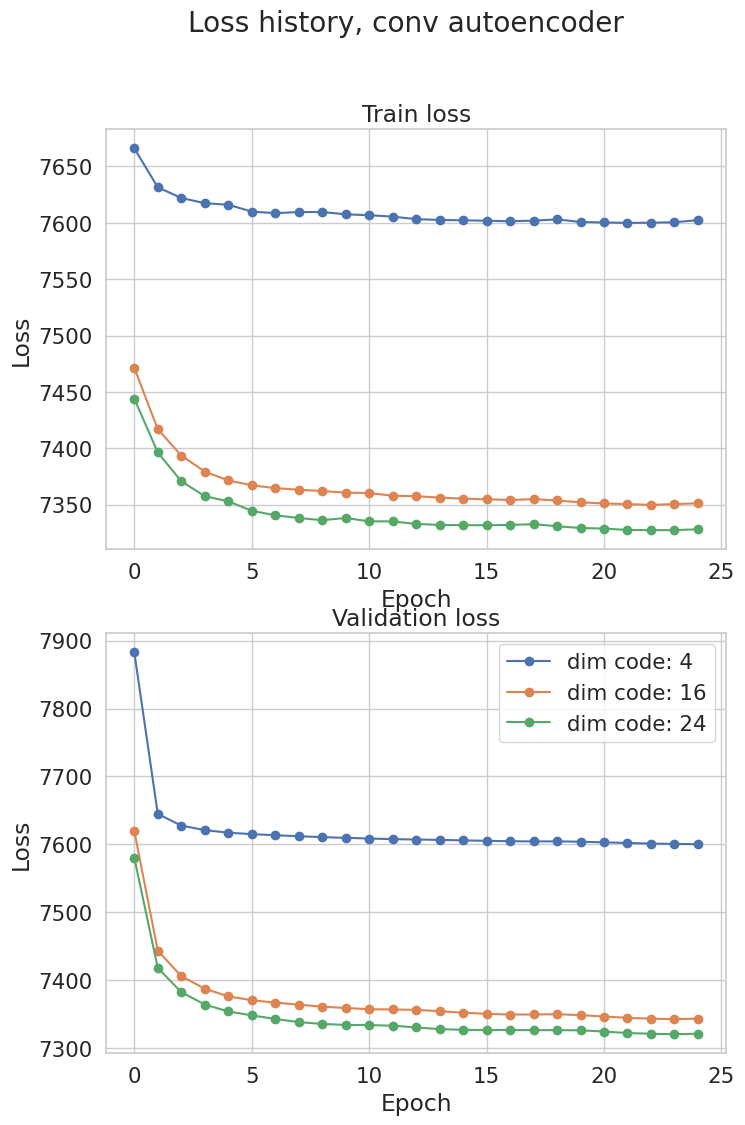

In [20]:
handle_history('conv')

Model type:  linear
Dim code:  4
Val loss:  7484.680088521863
Training time:  757.4322490692139
Dim code:  16
Val loss:  7381.720091195342
Training time:  770.1361925601959
Dim code:  24
Val loss:  7389.719996138308
Training time:  793.2485337257385


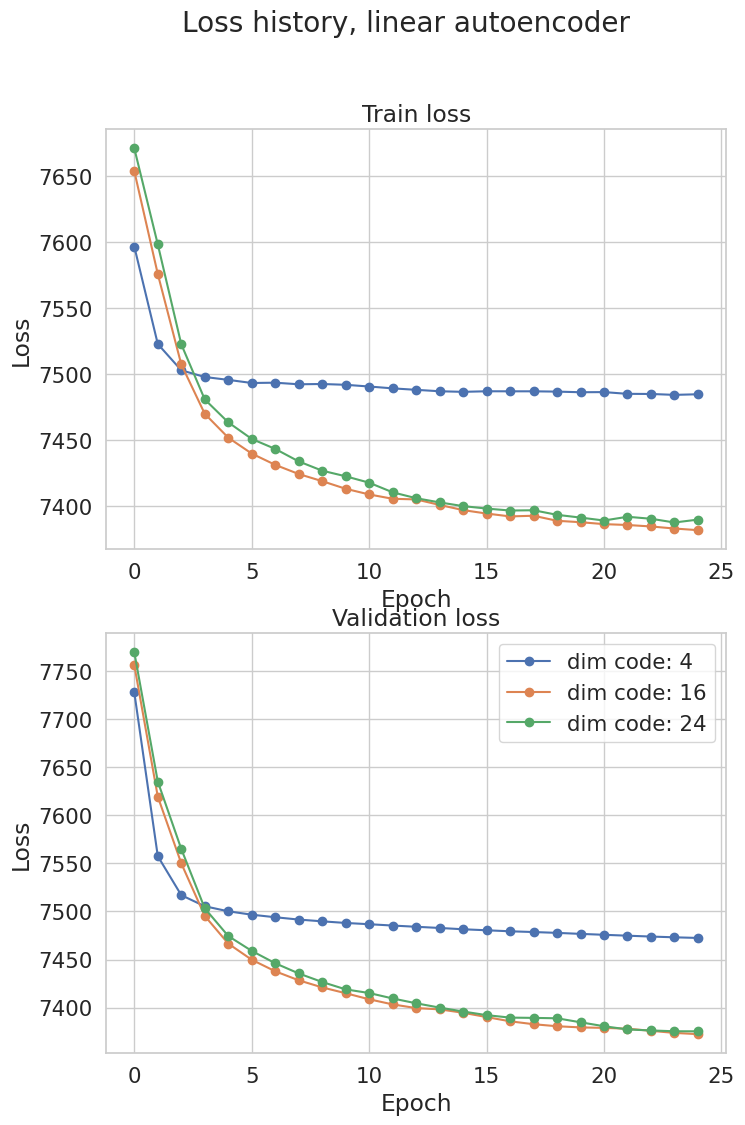

In [21]:
handle_history('linear')

Таким образом, с использованием свёрточного автоэнкодера удаётся добиться меньшего значения функции потерь, чем с использованием линейнго. Причём оптимальная размерность латентного пространства для свёрточного автоэнкодера $-$ 24 * 24, для линейного $-$ 16 * 16.

### Reconstruct test

In [22]:
best_conv_model = autoencoders['conv'][2]
best_linear_model = autoencoders['linear'][1]

In [23]:
def reconstruct(model):
    sns.set(style='white', font_scale=1.4)

    X_val = next(iter(val_loader))
    reconstruction = model(X_val.to(device))

    plt.figure(figsize=(24, 12))
    plt.tight_layout()
    for i, image in enumerate(reconstruction):
        plt.subplot(1, len(reconstruction), i + 1)
        skimage.io.imshow(np.rollaxis(image.detach().cpu().numpy(), 0, 3))
    plt.show()

Попробуем подать на вход автоэнкодеров изображения из валидационной выборки:

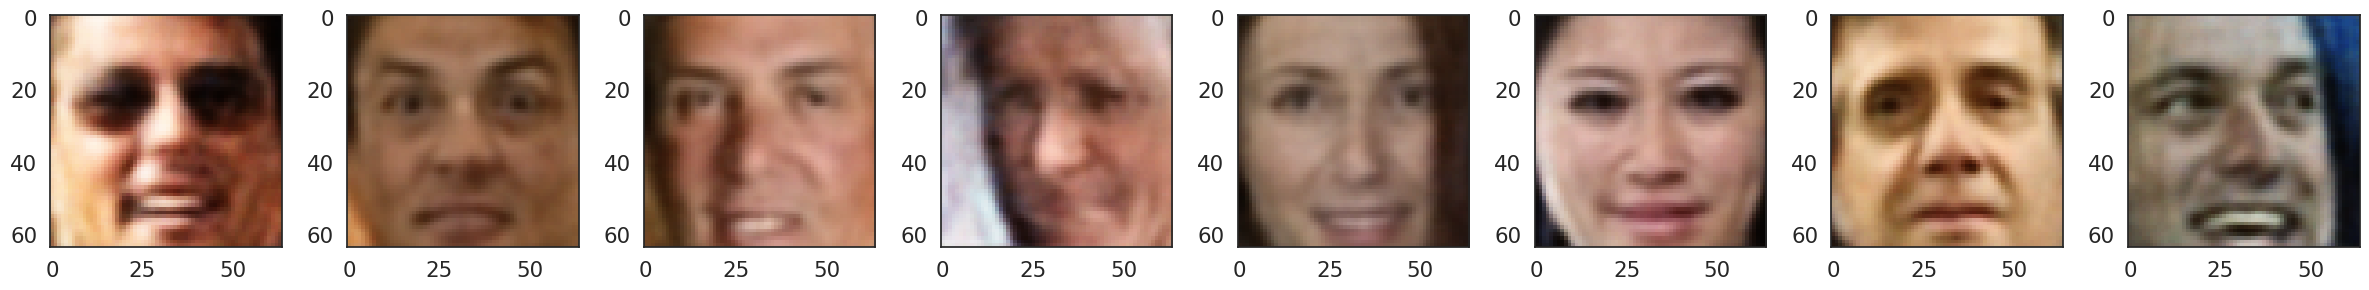

In [24]:
reconstruct(best_conv_model)

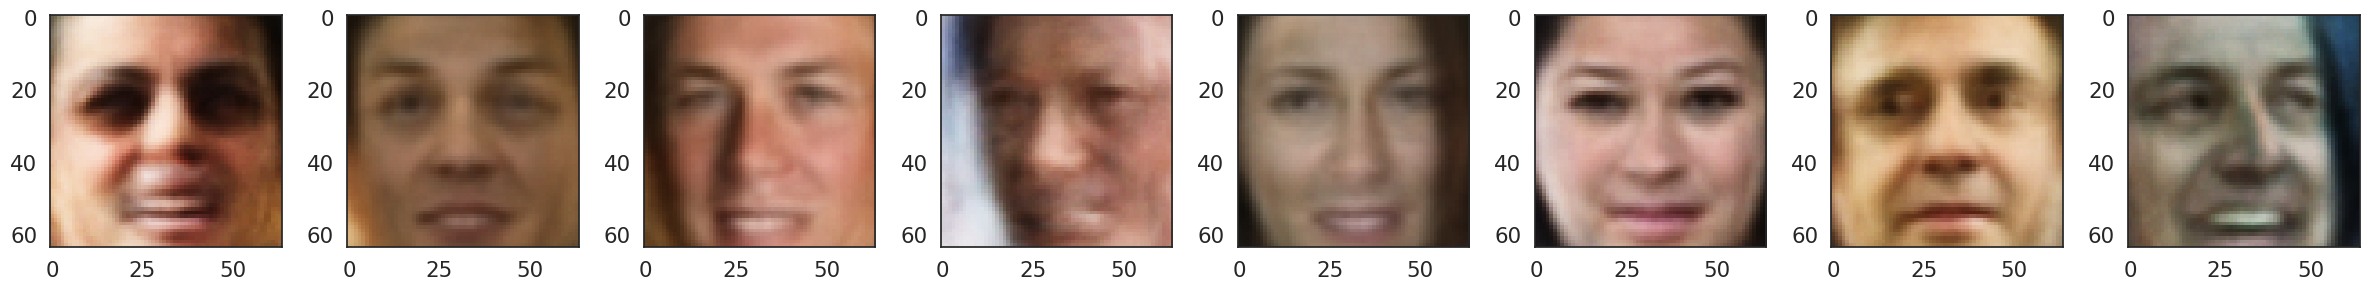

In [25]:
reconstruct(best_linear_model)

Действительно, свёрточный автоэнкодер выдаёт более чёткую картинку.

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [26]:
def sample(autoencoder, latent_space_dim):
    z = torch.Tensor(np.random.randn(10, latent_space_dim**2)).to(device)
    output = torch.sigmoid(autoencoder.decoder(z))

    sns.set(style='white', font_scale=1.4)

    plt.figure(figsize=(24, 12))
    plt.tight_layout()
    for i, image in enumerate(output):
        plt.subplot(1, 10, i + 1)
        skimage.io.imshow(np.rollaxis(image.detach().cpu().numpy(), 0, 3))

    plt.show()

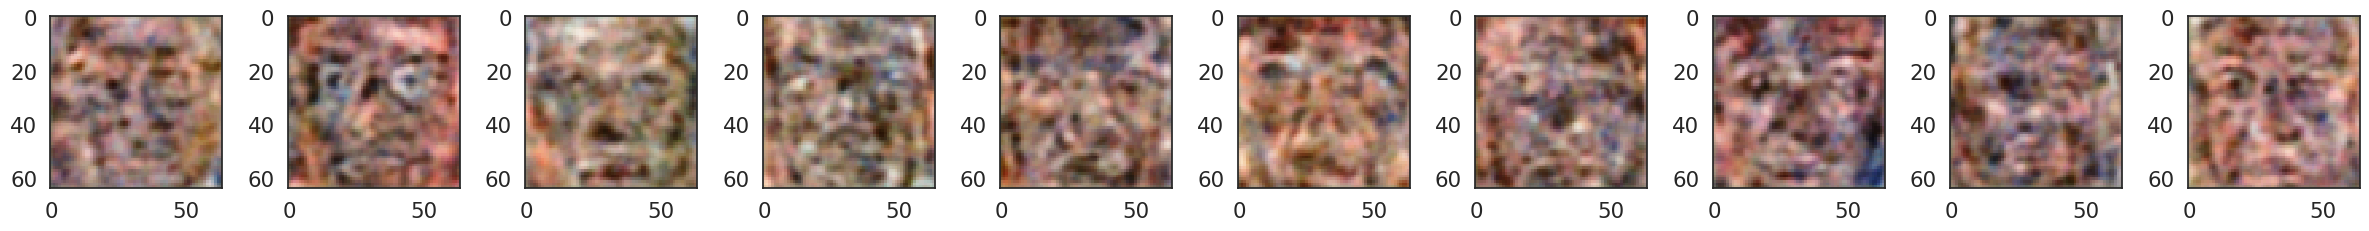

In [27]:
sample(best_conv_model, 24)

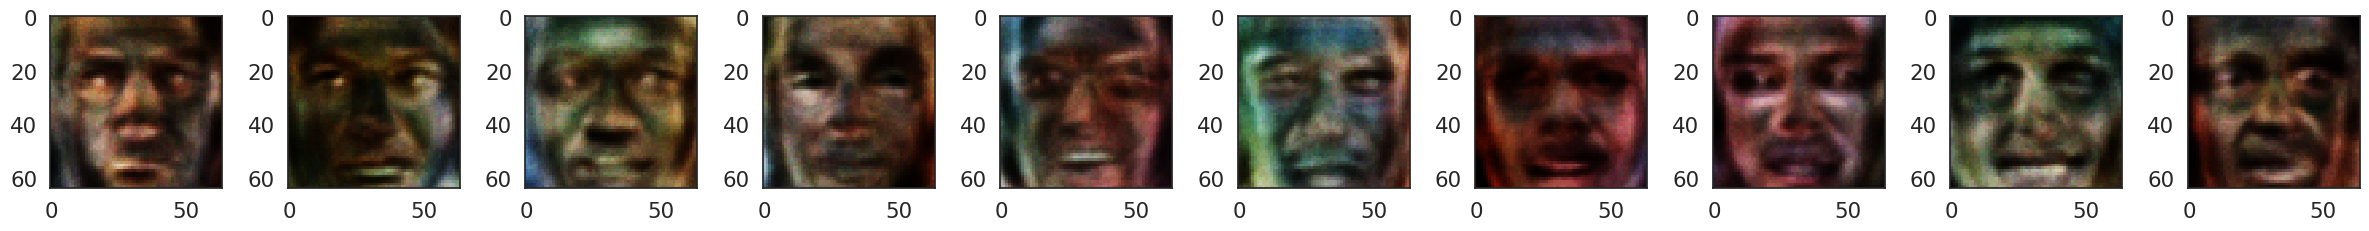

In [28]:
sample(best_linear_model, 16)

Как мы видим, линейному автоэнкодеру удалось лучше восстановить структуру лица человека в предположении, что латентные векторы имеют стандартное нормальное распределение.

Чтобы засэмплить фотографию, похожую на реальную (т.е. сгенерировать фотографию), на вход декодеру надо подать латентный вектор из реального распределения. Предположим, что реальное распределение $-$ нормальное. Найдём среднее значение $\mu_{val}$ латентных векторов в первом батче валидационной выборке, а также его дисперсию $\sigma_{val}^2$. Далее рассмотрим произвольный вектор из нормального распределения с соответствующими параметрами сдвига и дисперсии.

**Замечание.** Сдвиг и дисперсия для каждой из компонент (координат) латентного пространства считаются по отдельности.

Итак, алгоритм:

1. Сгенерировать векторы из стандартного нормального распределения. Дисперсия по каждой из компонент будет примерно равна 1, сдвиг $-$ нулю
2. Умножить получившиеся векторы на корень из дисперсии $\sqrt{\sigma_{val}^2}$ латентных векторов первого батча виладационной выборки. Дисперсия получившихся векторов станет примерно равной $\sigma_{val}^2$
3. Сдвинуть получившиеся векторы на $\mu_{val}$. Среднее значение полученных векторов станет примерно равным $\mu_{val}$

Таким образом мы получим латентные векторы из того же распределения, что и латентные векторы первого батча валидационной выборки, в предположении, что они из нормального распределения.

In [29]:
def sample(autoencoder, latent_space_dim):
    X = next(iter(val_loader))
    latent_code = autoencoder.encoder(torch.Tensor(X).to(device))

    mu = torch.mean(latent_code, axis=0, keepdims=True)
    var = torch.var(latent_code, axis=0, keepdims=True)

    z = mu + torch.Tensor(np.random.randn(10, latent_space_dim**2)).to(device) * torch.sqrt(var)
    output = torch.sigmoid(autoencoder.decoder(z))

    sns.set(style='white', font_scale=1.4)

    plt.figure(figsize=(24, 12))
    plt.tight_layout()
    for i, image in enumerate(output):
        plt.subplot(1, 10, i + 1)
        skimage.io.imshow(np.rollaxis(image.detach().cpu().numpy(), 0, 3))

    plt.show()

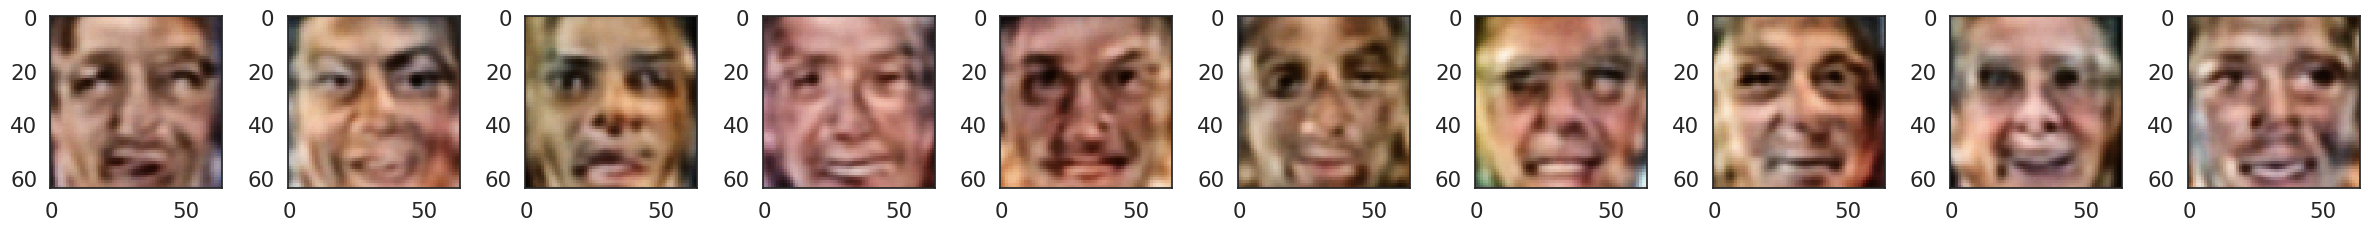

In [30]:
sample(best_conv_model, 24)

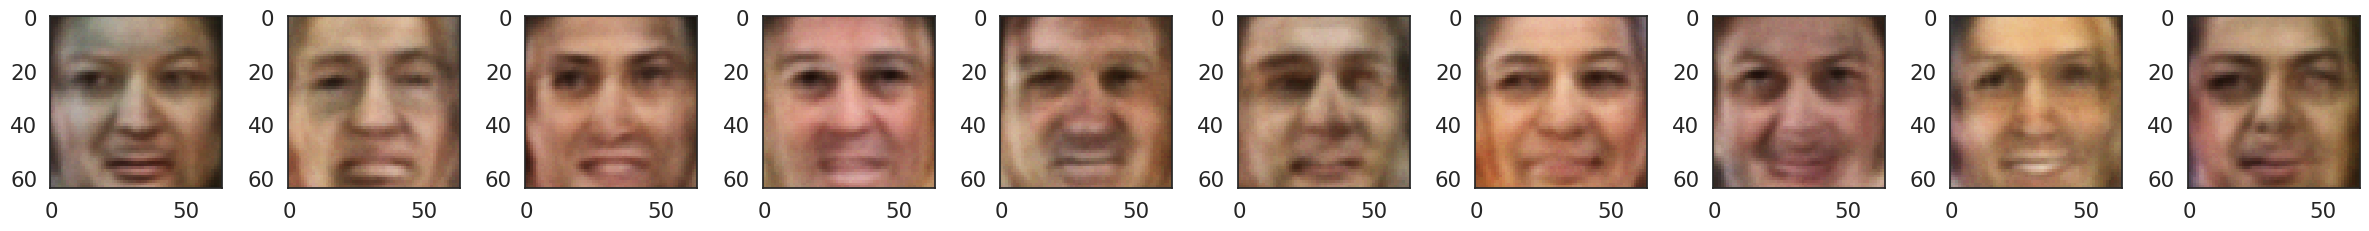

In [31]:
sample(best_linear_model, 16)

Даже после попытки приблизиться к реальному распределению латентных векторов линейный автоэнкодер выдаёт лучший результат. Свёрточный автоэнкодер всё также плохо семплирует изображения.

 Рассмотрим выпуклую линейную комбинацию латентных векторов некоторой подвыборки реальных фотографий. Можно предположить, что полученный вектор будет принадлежать реальному распределению. Поэтому р
 ассмотрим латентные векторы реальных фотографий, возьмём их выпуклую линейную комбинацию и засемплируем:

In [32]:
def linear_comb(autoencoder):
    sns.set(style='white', font_scale=1.4)

    plt.figure(figsize=(24, 24))
    plt.tight_layout()

    image_1 = train_photos[0]
    image_2 = train_photos[295]

    for i, alpha in enumerate(np.linspace(0, 1.00001, 10)):
        latent_code_1 = autoencoder.encoder(torch.permute(image_1[None, :], (0, 3, 1, 2)).to(device))
        latent_code_2 = autoencoder.encoder(torch.permute(image_2[None, :], (0, 3, 1, 2)).to(device))
        latent_code = (1 - alpha) * latent_code_1 + alpha * latent_code_2

        output = torch.sigmoid(autoencoder.decoder(latent_code))
        image = output[0]
        plt.subplot(1, 10, i + 1)
        skimage.io.imshow(np.rollaxis(image.detach().cpu().numpy(), 0, 3))

    plt.show()

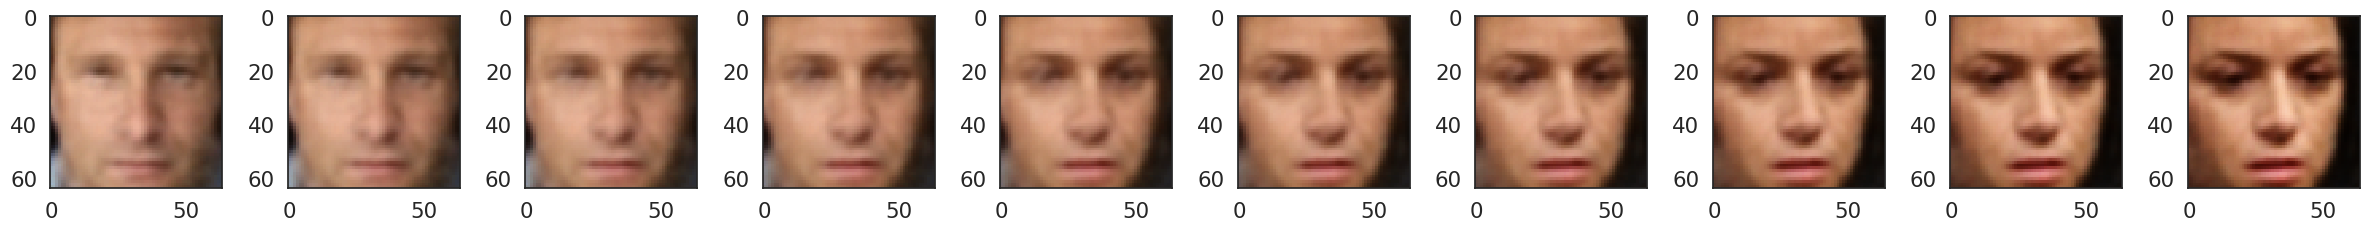

In [33]:
linear_comb(best_conv_model)

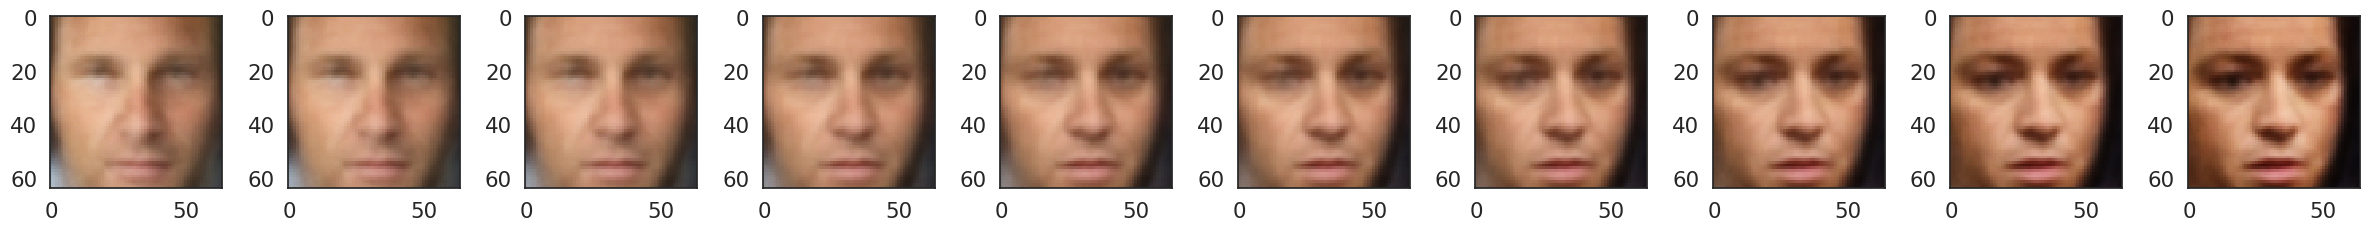

In [34]:
linear_comb(best_linear_model)

Ещё раз отметим, что свёрточный автоэнкодер лучше восстанавливает исходные изображения.

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [35]:
attrs.head()

Male     Asian     White     Black      Baby     Child     Youth  \
0  1.568346 -1.889043  1.737203 -0.929729 -1.471799  -0.19558 -0.835609   
1  0.169851 -0.982408  0.422709 -1.282184  -1.36006 -0.867002 -0.452293   
2  0.997749 -1.364195 -0.157377 -0.756447 -1.891825 -0.871526 -0.862893   
3  1.122719 -1.997799  1.916144 -2.514214 -2.580071 -1.404239  0.057551   
4  1.078214 -2.008098  1.676211 -2.278056 -2.651845 -1.348408  0.649089   

  Middle Aged    Senior Black Hair  ... Pale Skin 5 o' Clock Shadow  \
0   -0.351468 -1.012533  -0.719593  ...  0.361738          1.166118   
1   -0.197521 -0.956073  -0.802107  ... -0.832036          -0.39768   
2    0.031445 -1.341523  -0.090037  ...  1.549743          1.884745   
3    0.000196 -1.273512  -1.431462  ...  0.567822         -0.176089   
4    0.017656 -1.889111  -1.857213  ... -1.461474         -0.955283   

  Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
0               -1.164916         -1.13999    -2.371746       -1.299932   
1                 0.87416        -0.945431    -0.268649       -0.006244   
2               -0.999765        -1.359858    -1.912108       -1.095634   
3                1.108125        -1.600944    -3.264613        0.813418   
4                0.119113        -1.128176    -3.161048         0.08268   

  Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  
0  -0.414682        -1.144902        0.694007        -0.826609  
1  -0.030406        -0.480128         0.66676        -0.496559  
2   0.915126        -0.572332        0.144262        -0.841231  
3   0.308631        -0.848693        0.475941        -0.447025  
4  -0.439614        -0.359859       -0.760774        -0.410152  

[5 rows x 73 columns]

In [36]:
np.sort(attrs.columns)

array(["5 o' Clock Shadow", 'Arched Eyebrows', 'Asian', 'Attractive Man',
       'Attractive Woman', 'Baby', 'Bags Under Eyes', 'Bald', 'Bangs',
       'Big Lips', 'Big Nose', 'Black', 'Black Hair', 'Blond Hair',
       'Blurry', 'Brown Eyes', 'Brown Hair', 'Bushy Eyebrows', 'Child',
       'Chubby', 'Color Photo', 'Curly Hair', 'Double Chin', 'Eyeglasses',
       'Eyes Open', 'Flash', 'Flushed Face', 'Frowning',
       'Fully Visible Forehead', 'Goatee', 'Gray Hair', 'Harsh Lighting',
       'Heavy Makeup', 'High Cheekbones', 'Indian', 'Male', 'Middle Aged',
       'Mouth Closed', 'Mouth Slightly Open', 'Mouth Wide Open',
       'Mustache', 'Narrow Eyes', 'No Beard', 'No Eyewear',
       'Obstructed Forehead', 'Outdoor', 'Oval Face', 'Pale Skin',
       'Partially Visible Forehead', 'Pointy Nose', 'Posed Photo',
       'Receding Hairline', 'Rosy Cheeks', 'Round Face', 'Round Jaw',
       'Senior', 'Shiny Skin', 'Sideburns', 'Smiling', 'Soft Lighting',
       'Square Face', 'Straight H

In [37]:
attrs['Smiling']

0        -0.86499
1        0.798544
2        0.172817
3        0.563327
4        0.507786
           ...   
13138   -1.001434
13139    -0.64957
13140    0.475018
13141    0.741653
13142   -1.667977
Name: Smiling, Length: 13143, dtype: object

In [38]:
n = 50
attrs.sort_values(by=['Smiling'], ascending=False, inplace=True)
with_smile = attrs.head(n).index
without_smile = torch.IntTensor(np.random.choice(attrs.index[10000:], size=n)).to(torch.int32)

In [39]:
def plot_by_idxs(idxs):
    sns.set(style='white', font_scale=1.4)

    plt.figure(figsize=(16, 8))
    plt.tight_layout()

    n = len(idxs)
    for i in range(n):
        plt.subplot(n // 10, 10, i + 1)
        image = data[idxs[i]]
        skimage.io.imshow(torch.FloatTensor(image).numpy())

    plt.show()

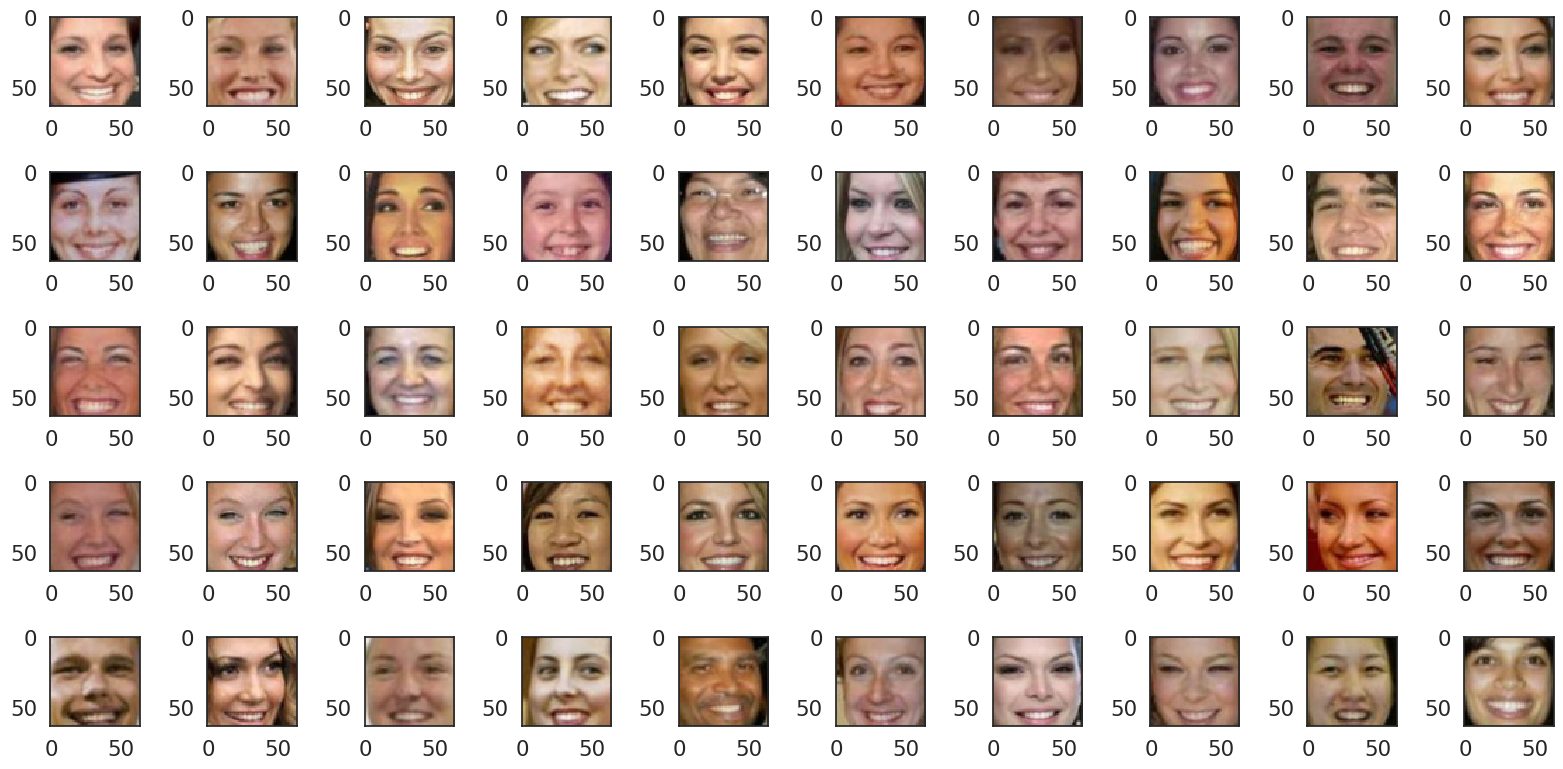

In [40]:
plot_by_idxs(with_smile)

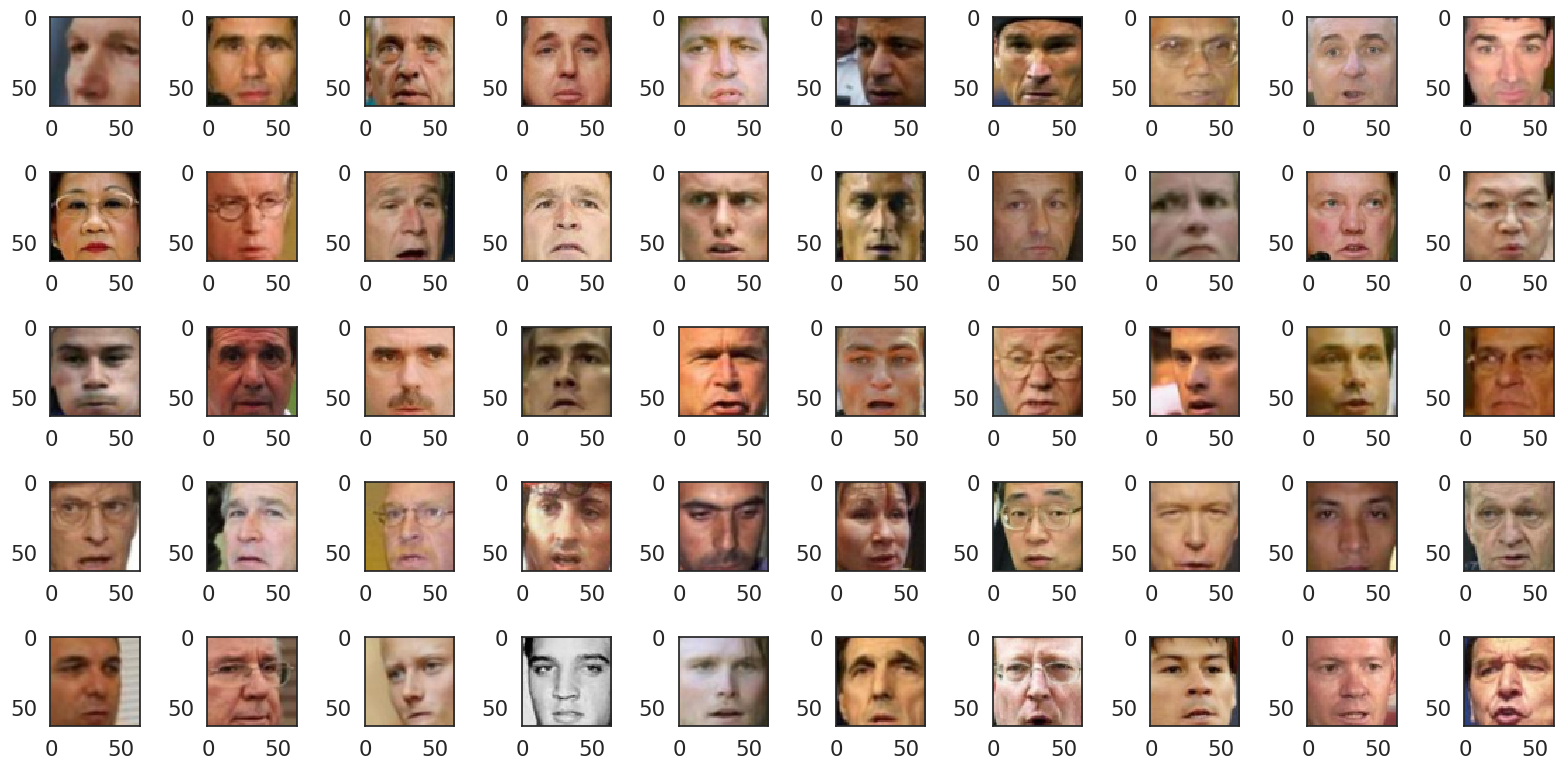

In [41]:
plot_by_idxs(without_smile)

Рассмотрим произвольные фотографии без улыбки:

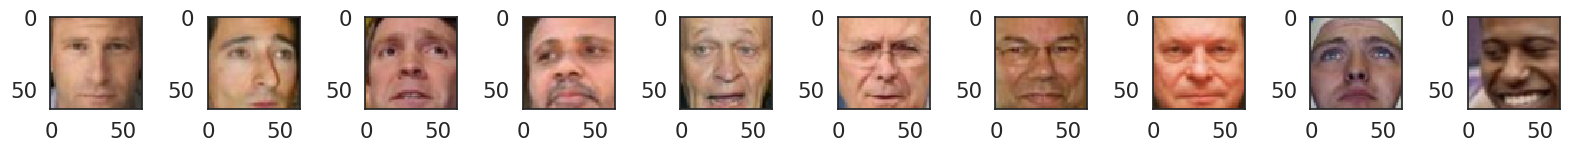

In [42]:
idxs = [0, 100, 1241, 8592, 5907, 2992, 2211, 11947, 10326, 12124]
images = data[idxs]
plot_by_idxs(idxs)

Добавим улыбки:

In [43]:
def get_smile(autoencoder):
    latent_code_smile_mean = autoencoder.encoder(torch.permute(torch.FloatTensor(data[with_smile]), (0, 3, 1, 2)).to(device))
    latent_code_no_smile_mean = autoencoder.encoder(torch.permute(torch.FloatTensor(data[without_smile]), (0, 3, 1, 2)).to(device))
    smile = torch.mean(latent_code_smile_mean, axis=0, keepdims=True) - torch.mean(latent_code_no_smile_mean, axis=0, keepdims=True)

    return smile

In [44]:
def add_smile(autoencoder, images):
    smile = get_smile(autoencoder)

    latent_code = autoencoder.encoder(torch.permute(torch.FloatTensor(images), (0, 3, 1, 2)).to(device))
    latent_code += smile
    result = torch.sigmoid(autoencoder.decoder(latent_code))

    return result

In [45]:
def plot_images(images):
    sns.set(style='white', font_scale=1.4)

    plt.figure(figsize=(20, 16))

    for i, image in enumerate(images):
        plt.subplot(1, 10, i + 1)
        skimage.io.imshow(np.rollaxis(images[i].detach().cpu().numpy(), 0, 3))

    plt.show()

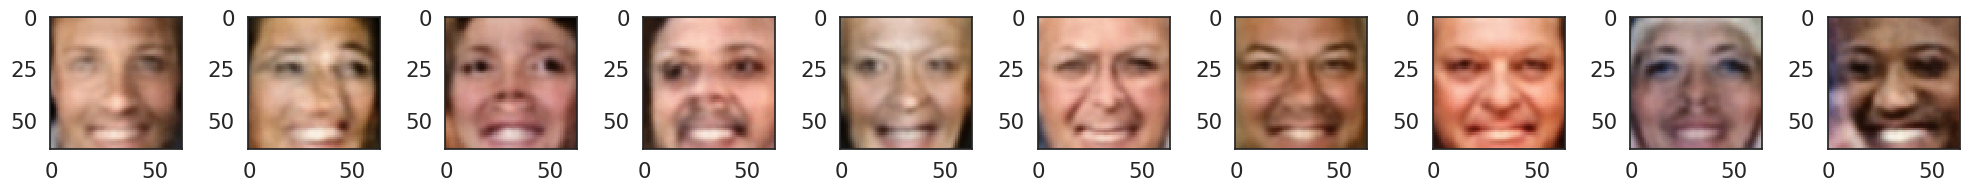

In [46]:
smiling_images = add_smile(best_conv_model, images)
plot_images(smiling_images)

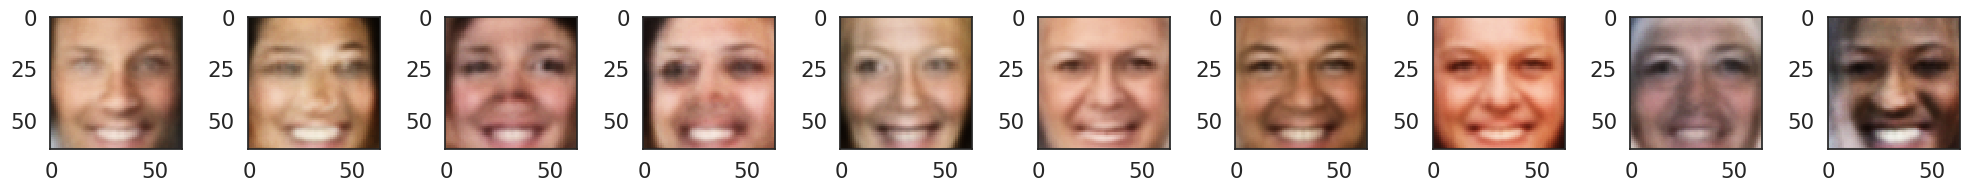

In [47]:
smiling_images = add_smile(best_linear_model, images)
plot_images(smiling_images)

Оба автоэнкодера отлично справились с поставленной задачей.

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [48]:
from torchvision import transforms

In [110]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [50]:
criterion = nn.BCELoss(reduction='sum')

variational_autoencoders = {
    'conv': [],
    'linear': []
}
vae_history = {
    'conv': [],
    'linear': []
}

### Convolutional VAE

In [51]:
class ConvolutionalVAE(nn.Module):
    class Encoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
            self.fc = nn.Linear(32 * 28**2, 16**2 * 2)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = torch.flatten(x, start_dim=1)
            x = self.fc(x)
            x = x.reshape(x.shape[0], 2, 16**2)

            mu = x[:, 0, :]
            logsigma = x[:, 1, :]

            return mu, logsigma

    class Decoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc = nn.Linear(16**2, 32 * 28**2)
            self.deconv1 = nn.ConvTranspose2d(32, 64, kernel_size=3, padding=1)
            self.deconv2 = nn.ConvTranspose2d(64, 1, kernel_size=3, padding=1)

        def forward(self, x):
            x = F.relu(self.fc(x))
            x = x.reshape(x.shape[0], 32, 28, 28)
            x = F.relu(self.deconv1(x))
            x = self.deconv2(x)
            return x

    def __init__(self):
        super().__init__()
        self.encoder = self.Encoder()
        self.decoder = self.Decoder()

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(logsigma) ** 0.5
            eps = torch.randn_like(mu)
            sample = mu + eps * std
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def forward(self, x):
        mu, logsigma = self.encoder(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = torch.sigmoid(self.decoder(z))

        return mu, logsigma, reconstruction

### Linear VAE

In [52]:
class LinearVAE(nn.Module):

    class Encoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.encode = nn.Sequential(
                nn.Flatten(start_dim=1),
                nn.Linear(28**2, 1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, 2 * 16**2),
                nn.Unflatten(dim=1, unflattened_size=(2, 16**2))
            )

        def forward(self, x):
            encoded = self.encode(x)
            mu = encoded[:,0,:]
            logsigma = encoded[:,1,:]
            return mu, logsigma

    class Decoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.decode = nn.Sequential(
                nn.Linear(16**2, 512),
                nn.ReLU(),
                nn.Linear(512, 1024),
                nn.ReLU(),
                nn.Linear(1024, 28**2),
                nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
            )

        def forward(self, latent):
            reconstruction = self.decode(latent)
            return reconstruction


    def __init__(self):
        super().__init__()
        self.encoder = self.Encoder()
        self.decoder = self.Decoder()

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            z = torch.randn_like(mu)
            z *= torch.exp(logsigma) ** 0.5
            z += mu
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def forward(self, x):
        mu, logsigma = self.encoder(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decoder(z)
        reconstruction = torch.sigmoid(reconstruction)
        return mu, logsigma, reconstruction

## 2.2 Обучение

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [53]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -1/2 * torch.sum(1 + logsigma - mu**2 - torch.exp(logsigma), axis=1, keepdims=True)
    return torch.sum(loss)

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [54]:
def eval_epoch_2(model, data_loader, criterion, conditional=False):
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        processed_size = 0

        for X, labels in data_loader:
            X = X.to(device)
            labels = labels.to(device)
            if conditional:
                mu, logsigma, reconstruction = model(X, labels)
            else:
                mu, logsigma, reconstruction = model(X)

            loss = criterion(X, mu, logsigma, reconstruction)
            running_loss += loss.item()
            processed_size += len(X)

    return running_loss / processed_size

In [55]:
def fit_epoch_2(model, data_loader, optimizer, criterion, conditional=False):
    model.train()

    running_loss = 0.0
    processed_size = 0

    for X, labels in data_loader:
        X = X.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        if conditional:
            mu, logsigma, reconstruction = model(X, labels)
        else:
            mu, logsigma, reconstruction = model(X)

        loss = criterion(X, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        processed_size += len(X)

    return running_loss / processed_size

In [56]:
from tqdm import tqdm

def train_2(model, tr_loader, val_loader, optimizer, criterion, epochs, conditional=False):
    loss_history = []

    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            train_loss = fit_epoch_2(model, tr_loader, optimizer, criterion, conditional)
            print(f"Train loss: {train_loss}")
            val_loss = eval_epoch_2(model, val_loader, criterion, conditional)
            loss_history.append((train_loss, val_loss))
            print(f"Train loss: {train_loss}, val loss: {val_loss}")
            pbar.update(1)
    return loss_history

In [57]:
criterion = loss_vae
conv_vae = ConvolutionalVAE().to(device)
variational_autoencoders['conv'] = conv_vae
optimizer = torch.optim.AdamW(conv_vae.parameters(), lr=0.0001)
hist = train_2(conv_vae, train_loader, val_loader, optimizer, criterion, 25)
vae_history['conv'] = hist

  0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 163.26134476273148


  4%|▍         | 1/25 [00:19<07:51, 19.66s/it]

Train loss: 163.26134476273148, val loss: 130.77653548177082
Train loss: 134.85010605197482


  8%|▊         | 2/25 [00:39<07:29, 19.56s/it]

Train loss: 134.85010605197482, val loss: 119.90915799967448
Train loss: 126.77511993860315


 12%|█▏        | 3/25 [00:58<07:09, 19.53s/it]

Train loss: 126.77511993860315, val loss: 115.21203214518229
Train loss: 120.78563843677662


 16%|█▌        | 4/25 [01:18<06:48, 19.47s/it]

Train loss: 120.78563843677662, val loss: 111.52930293782552
Train loss: 116.72479954020183


 20%|██        | 5/25 [01:37<06:31, 19.57s/it]

Train loss: 116.72479954020183, val loss: 108.34859326171875
Train loss: 113.95073326506439


 24%|██▍       | 6/25 [01:57<06:11, 19.55s/it]

Train loss: 113.95073326506439, val loss: 106.2278651529948
Train loss: 111.9063684443721


 28%|██▊       | 7/25 [02:16<05:51, 19.50s/it]

Train loss: 111.9063684443721, val loss: 105.31494694010416
Train loss: 110.31371999104817


 32%|███▏      | 8/25 [02:36<05:31, 19.51s/it]

Train loss: 110.31371999104817, val loss: 102.30035705566407
Train loss: 109.0464573409469


 36%|███▌      | 9/25 [02:55<05:11, 19.47s/it]

Train loss: 109.0464573409469, val loss: 103.50874344889323
Train loss: 108.12324733253762


 40%|████      | 10/25 [03:15<04:52, 19.48s/it]

Train loss: 108.12324733253762, val loss: 102.40044150797526
Train loss: 107.27974046269169


 44%|████▍     | 11/25 [03:34<04:32, 19.47s/it]

Train loss: 107.27974046269169, val loss: 99.53042692057292
Train loss: 106.6206001180013


 48%|████▊     | 12/25 [03:53<04:12, 19.46s/it]

Train loss: 106.6206001180013, val loss: 99.7852172241211
Train loss: 106.1118032723886


 52%|█████▏    | 13/25 [04:13<03:53, 19.48s/it]

Train loss: 106.1118032723886, val loss: 98.45666532389323
Train loss: 105.56953688783999


 56%|█████▌    | 14/25 [04:32<03:34, 19.46s/it]

Train loss: 105.56953688783999, val loss: 98.70414278157553
Train loss: 105.13694832808883


 60%|██████    | 15/25 [04:52<03:14, 19.48s/it]

Train loss: 105.13694832808883, val loss: 97.64449104817709
Train loss: 104.7300603886357


 64%|██████▍   | 16/25 [05:11<02:55, 19.45s/it]

Train loss: 104.7300603886357, val loss: 96.98845198567709
Train loss: 104.34860267017505


 68%|██████▊   | 17/25 [05:31<02:35, 19.46s/it]

Train loss: 104.34860267017505, val loss: 98.0927494506836
Train loss: 104.05409008789063


 72%|███████▏  | 18/25 [05:50<02:16, 19.45s/it]

Train loss: 104.05409008789063, val loss: 97.09738102213542
Train loss: 103.70550842737269


 76%|███████▌  | 19/25 [06:10<01:56, 19.46s/it]

Train loss: 103.70550842737269, val loss: 97.81108782958984
Train loss: 103.52454267487703


 80%|████████  | 20/25 [06:29<01:37, 19.46s/it]

Train loss: 103.52454267487703, val loss: 95.76384075927734
Train loss: 103.2252139666522


 84%|████████▍ | 21/25 [06:49<01:17, 19.43s/it]

Train loss: 103.2252139666522, val loss: 95.77755834960938
Train loss: 103.04201625343606


 88%|████████▊ | 22/25 [07:08<00:58, 19.50s/it]

Train loss: 103.04201625343606, val loss: 94.9325498046875
Train loss: 102.79033718080873


 92%|█████████▏| 23/25 [07:28<00:38, 19.47s/it]

Train loss: 102.79033718080873, val loss: 96.26439255777994
Train loss: 102.5768305166739


 96%|█████████▌| 24/25 [07:47<00:19, 19.48s/it]

Train loss: 102.5768305166739, val loss: 95.2604077758789
Train loss: 102.38158940746166


100%|██████████| 25/25 [08:07<00:00, 19.48s/it]

Train loss: 102.38158940746166, val loss: 95.58713317871094


In [58]:
criterion = loss_vae
linear_vae = LinearVAE().to(device)
variational_autoencoders['linear'] = linear_vae
optimizer = torch.optim.AdamW(linear_vae.parameters(), lr=0.0001)
hist = train_2(linear_vae, train_loader, val_loader, optimizer, criterion, 25)
vae_history['linear'] = hist

  0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 193.21362075014468


  4%|▍         | 1/25 [00:07<02:57,  7.41s/it]

Train loss: 193.21362075014468, val loss: 171.2283221842448


  8%|▊         | 2/25 [00:14<02:45,  7.19s/it]

Train loss: 156.8374514114945
Train loss: 156.8374514114945, val loss: 144.88659025065104


 12%|█▏        | 3/25 [00:21<02:41,  7.35s/it]

Train loss: 147.42383436414931
Train loss: 147.42383436414931, val loss: 134.68495674641926


 16%|█▌        | 4/25 [00:28<02:30,  7.17s/it]

Train loss: 141.17260703757958
Train loss: 141.17260703757958, val loss: 126.63110310872396


 20%|██        | 5/25 [00:36<02:26,  7.31s/it]

Train loss: 135.15584514702692
Train loss: 135.15584514702692, val loss: 122.06222139485678


 24%|██▍       | 6/25 [00:43<02:16,  7.16s/it]

Train loss: 128.69820239257814
Train loss: 128.69820239257814, val loss: 116.0474312133789


 28%|██▊       | 7/25 [00:50<02:10,  7.25s/it]

Train loss: 123.51664282226562
Train loss: 123.51664282226562, val loss: 112.41416129557291


 32%|███▏      | 8/25 [00:57<02:01,  7.13s/it]

Train loss: 119.33310262948496
Train loss: 119.33310262948496, val loss: 109.58323598225911


 36%|███▌      | 9/25 [01:05<01:55,  7.24s/it]

Train loss: 115.6774858081959
Train loss: 115.6774858081959, val loss: 106.23588197835286


 40%|████      | 10/25 [01:11<01:46,  7.12s/it]

Train loss: 112.57197067599826
Train loss: 112.57197067599826, val loss: 105.17984733072916


 44%|████▍     | 11/25 [01:19<01:41,  7.23s/it]

Train loss: 110.275461932147
Train loss: 110.275461932147, val loss: 102.5215839436849
Train loss: 108.72243687608507


 48%|████▊     | 12/25 [01:26<01:33,  7.18s/it]

Train loss: 108.72243687608507, val loss: 101.39908154296874


 52%|█████▏    | 13/25 [01:33<01:26,  7.24s/it]

Train loss: 107.57287353063512
Train loss: 107.57287353063512, val loss: 100.4802977294922
Train loss: 106.5766931197555


 56%|█████▌    | 14/25 [01:41<01:19,  7.26s/it]

Train loss: 106.5766931197555, val loss: 99.85660799153646


 60%|██████    | 15/25 [01:48<01:12,  7.24s/it]

Train loss: 105.78560722746673
Train loss: 105.78560722746673, val loss: 98.62970882161459
Train loss: 105.07544269476996


 64%|██████▍   | 16/25 [01:55<01:05,  7.31s/it]

Train loss: 105.07544269476996, val loss: 98.04957661946615
Train loss: 104.39372371871383


 68%|██████▊   | 17/25 [02:02<00:57,  7.22s/it]

Train loss: 104.39372371871383, val loss: 97.50938275146484


 72%|███████▏  | 18/25 [02:10<00:51,  7.34s/it]

Train loss: 103.86027616373698
Train loss: 103.86027616373698, val loss: 96.90098494466146


 76%|███████▌  | 19/25 [02:17<00:43,  7.23s/it]

Train loss: 103.37169592511212
Train loss: 103.37169592511212, val loss: 96.71178184000651


 80%|████████  | 20/25 [02:24<00:36,  7.31s/it]

Train loss: 102.87241702383535
Train loss: 102.87241702383535, val loss: 96.19336065673828


 84%|████████▍ | 21/25 [02:31<00:28,  7.18s/it]

Train loss: 102.37372620533131
Train loss: 102.37372620533131, val loss: 95.73681866455078


 88%|████████▊ | 22/25 [02:39<00:21,  7.29s/it]

Train loss: 102.03502887641059
Train loss: 102.03502887641059, val loss: 96.21007002766927


 92%|█████████▏| 23/25 [02:46<00:14,  7.16s/it]

Train loss: 101.65438071017795
Train loss: 101.65438071017795, val loss: 95.76165842692058


 96%|█████████▌| 24/25 [02:53<00:07,  7.28s/it]

Train loss: 101.27994611725984
Train loss: 101.27994611725984, val loss: 94.85858473714192
Train loss: 100.96748648410373


100%|██████████| 25/25 [03:00<00:00,  7.23s/it]

Train loss: 100.96748648410373, val loss: 94.77982491048176


In [59]:
def handle_history(model_type):
    sns.set(style='whitegrid', font_scale=1.4)

    print("Model type: ", model_type)
    hist = vae_history[model_type]

    plt.figure(figsize=(8, 4))

    # print("Val loss: ", hist[-1][1])
    # print("Training time: ", hist[-1][2])

    val_loss = np.array(hist)[:,0]
    train_loss = np.array(hist)[:,1]

    plt.plot(train_loss, marker='o', label=f'train')
    plt.plot(val_loss, marker='o', label=f'valid')


    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss history, {model_type} autoencoder')

    plt.legend()
    plt.show()

Model type:  linear


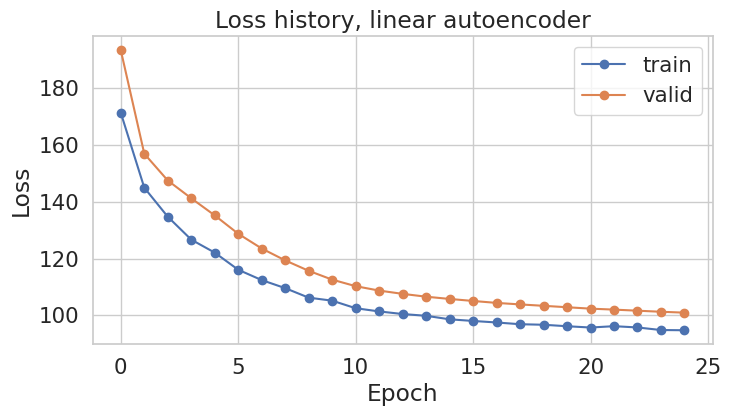

In [60]:
handle_history('linear')

Model type:  conv


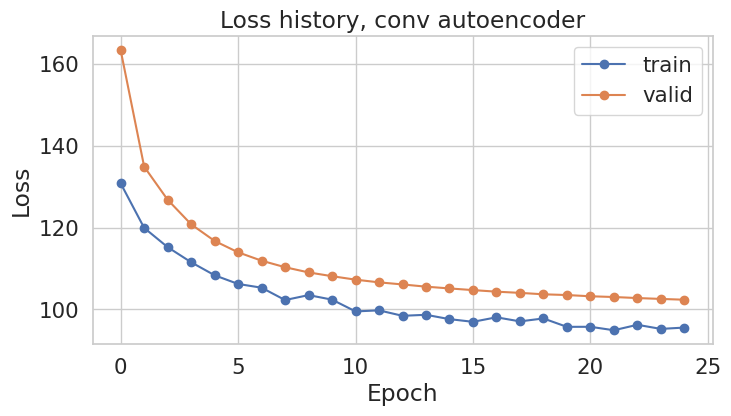

In [61]:
handle_history('conv')

Заметим, что значение функции потерь в задаче восстановления рукописных цифр на порядки меньше чем в задаче восстановления лиц, что вполне логично.

### Reconstruct test

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [62]:
def reconstruct(model, images):
    mu, logsigma, reconstruction = linear_vae(images)

    sns.set(style='white', font_scale=1.4)

    plt.figure(figsize=(24, 8))
    plt.tight_layout()

    for i in range(n):
        plt.subplot(n // 10, 10, i + 1)
        skimage.io.imshow(np.rollaxis(reconstruction[i].detach().cpu().numpy(), 0, 3))

    plt.show()


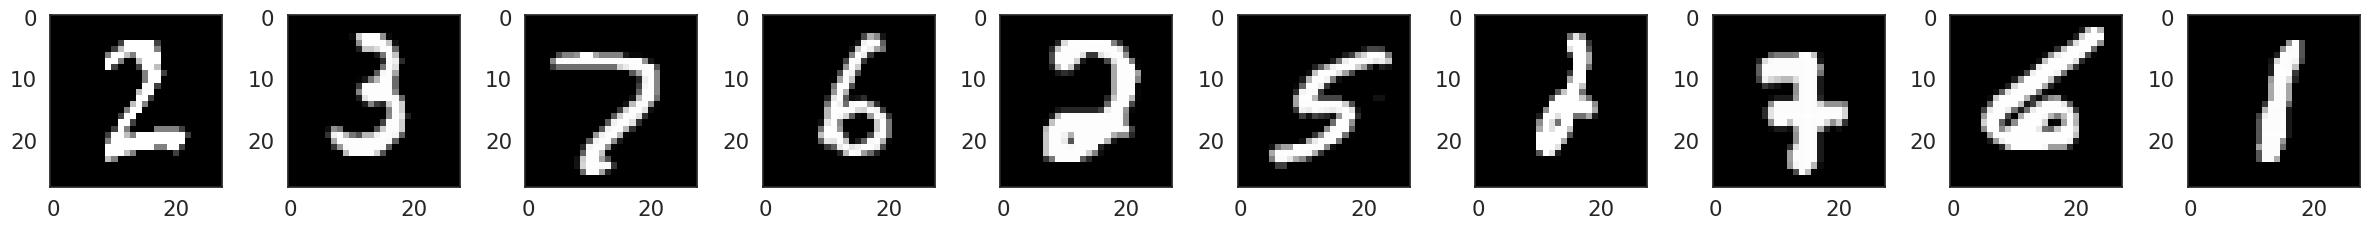

In [63]:
sns.set(style='white', font_scale=1.4)

plt.figure(figsize=(24, 8))
plt.tight_layout()

first_batch = next(iter(val_loader))
n = 10

for i in range(n):
    plt.subplot(n // 10, 10, i + 1)
    image = first_batch[0][i]
    skimage.io.imshow(np.rollaxis(image.cpu().numpy(), 0, 3))

plt.show()

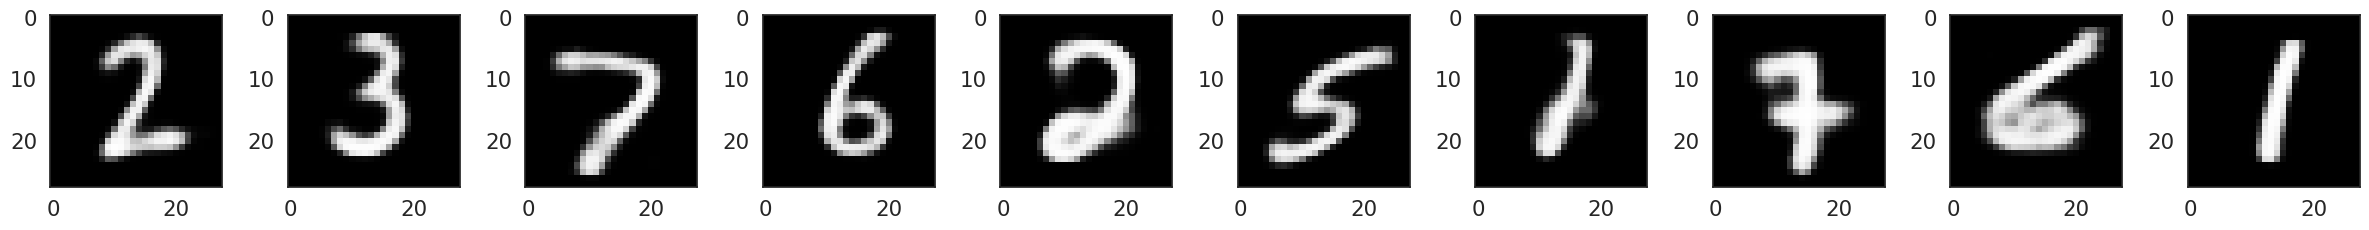

In [64]:
reconstruct(linear_vae, first_batch[0].to(device))

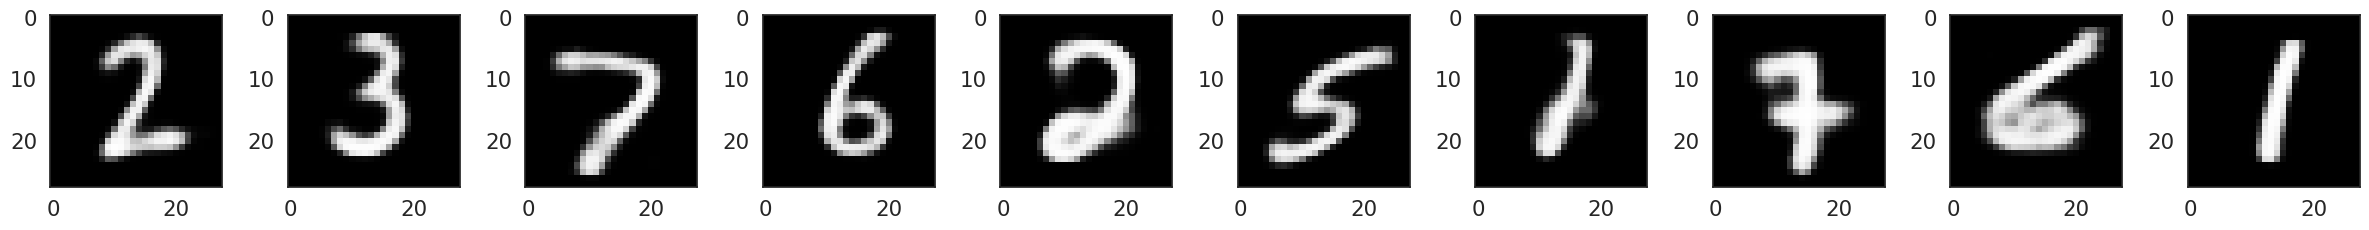

In [65]:
reconstruct(conv_vae, first_batch[0].to(device))

### Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются.

Вариационный автоэнкодер старается сделать распределение векторов латентного пространства стандартным нормальным. Проверим на примере первого батча валидационной выборки, насколько среднее значение латентных векторов близко к 0, а дисперсия $-$ к 1 (покомпонентно):

In [113]:
def sample(model):
    n = 10
    z = torch.Tensor(np.array([np.random.normal(0, 1, 16 * 16) for i in range(n)])).to(device)
    output = torch.sigmoid(linear_vae.decoder(z))

    sns.set(style='white', font_scale=1.4)

    plt.figure(figsize=(24, 8))
    plt.tight_layout()
    for i in range(n):
        plt.subplot(n // 10, 10, i + 1)
        skimage.io.imshow(np.rollaxis(output[i].detach().cpu().numpy(), 0, 3))

    plt.show()

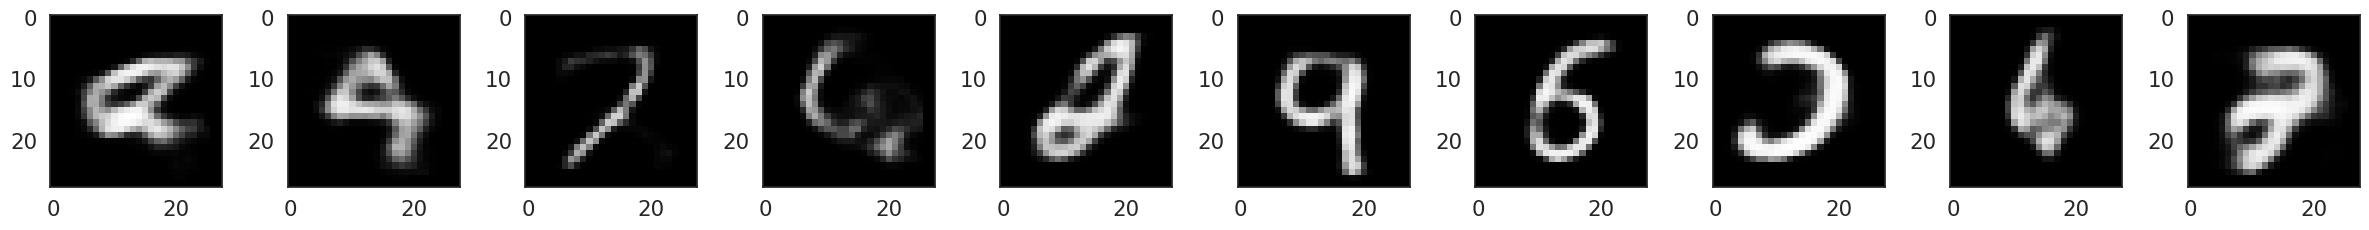

In [114]:
sample(linear_vae)

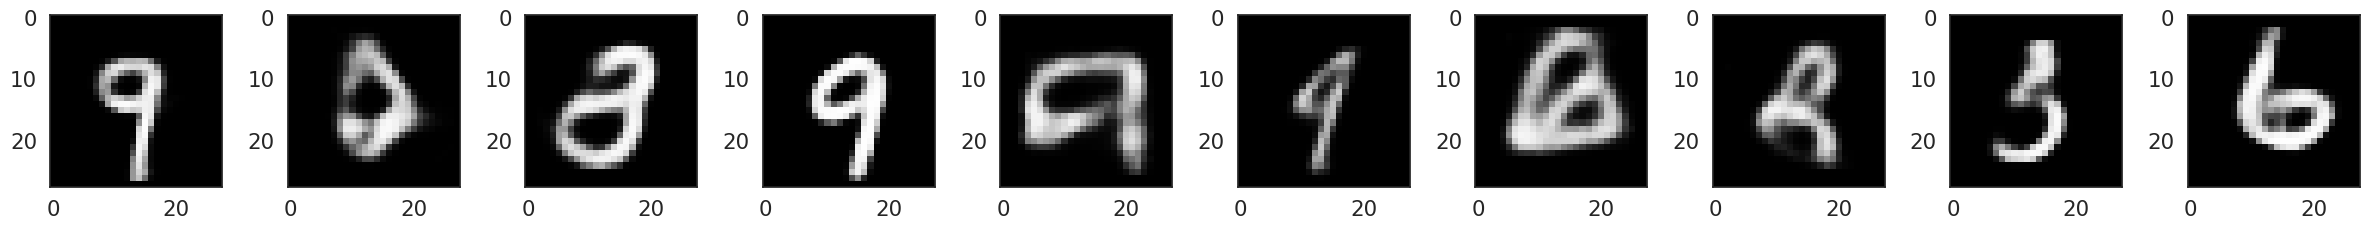

In [115]:
sample(conv_vae)

## 2.3. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [69]:
def get_latent_code(autoencoder, data_loader):
    latent_code = torch.Tensor().to(device)
    labels = torch.Tensor()
    for batch in data_loader:
        mu, logsigma = autoencoder.encoder(torch.Tensor(batch[0]).to(device))
        encoded = autoencoder.gaussian_sampler(mu, logsigma)
        if len(latent_code) == 0:
            latent_code = encoded
            labels = batch[1]
        else:
            latent_code = torch.vstack((latent_code, encoded))
            labels = torch.hstack((labels, batch[1]))

    return latent_code, labels

In [70]:
from sklearn.manifold import TSNE

def latent_represent(autoencoder, data_loader):
    latent_code, labels = get_latent_code(autoencoder, data_loader)
    print("Latent code: ", latent_code.shape)

    tsne = TSNE(n_components=2, verbose=1, random_state=42)
    z = tsne.fit_transform(latent_code.detach().cpu())

    df = pd.DataFrame()
    df["y"] = labels
    df["comp-1"] = z[:,0]
    df["comp-2"] = z[:,1]

    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                    palette=sns.color_palette("hls", 10),
                    data=df).set(title="MNIST data T-SNE projection")


Используем вариационный автоэнкодер с линейными слоями:

Latent code:  torch.Size([10000, 256])
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.122s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.120213
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.372810
[t-SNE] KL divergence after 1000 iterati

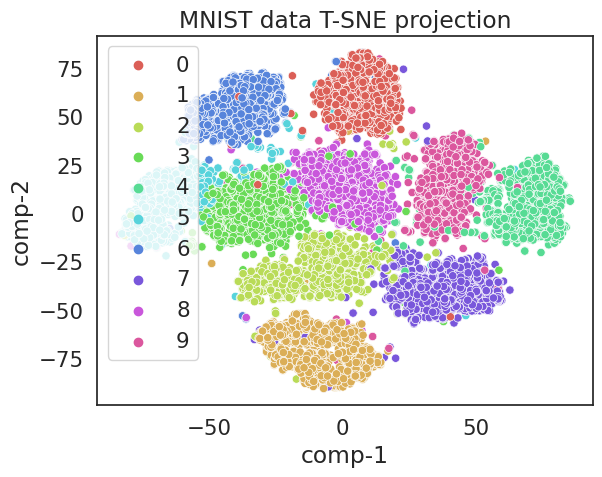

In [71]:
latent_represent(linear_vae, test_loader)

Латентное пространство с использованием вариационного автоэнкодера действительно сжато, вытянутные облака отсутствуют, классовые кластеры отличимы друг от друга.

## 2.4. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [72]:
criterion = nn.BCELoss(reduction='sum')

conditional_variational_autoencoders = {
    'conv': [],
    'linear': []
}
cvae_history = {
    'conv': [],
    'linear': []
}

### Convolutional CVAE

In [73]:
class ConvolutionalCVAE(nn.Module):

    class Encoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.encode = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(32 * 28**2, 2 * 16**2),
                nn.Unflatten(dim=1, unflattened_size=(2, 16**2))
            )

        def forward(self, x):
            encoded = self.encode(x)
            mu = encoded[:,0,:]
            logsigma = encoded[:,1,:]
            return mu, logsigma

    class Decoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.decode = nn.Sequential(
                nn.Linear(10 + 16**2, 28**2),
                nn.ReLU(),
                nn.Unflatten(dim=1, unflattened_size=(1, 28, 28)),
                nn.ConvTranspose2d(1, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 1, kernel_size=3, padding=1),
            )

        def forward(self, latent, label):
            one_hot_encoded_label = F.one_hot(label, num_classes=10)
            concatenated = torch.cat((one_hot_encoded_label, latent), dim=1)
            reconstruction = self.decode(concatenated)
            return reconstruction


    def __init__(self):
        super().__init__()
        self.encoder = self.Encoder()
        self.decoder = self.Decoder()

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            z = torch.randn_like(mu)
            z *= torch.exp(logsigma) ** 0.5
            z += mu
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def forward(self, x, label):
        mu, logsigma = self.encoder(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decoder(z, label)
        reconstruction = torch.sigmoid(reconstruction)
        return mu, logsigma, reconstruction

### Linear CVAE

In [74]:
class LinearCVAE(nn.Module):

    class Encoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.encode = nn.Sequential(
                nn.Flatten(start_dim=1),
                nn.Linear(28**2, 1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, 2 * 16**2),
                nn.Unflatten(dim=1, unflattened_size=(2, 16**2))
            )

        def forward(self, x):
            encoded = self.encode(x)
            mu = encoded[:,0,:]
            logsigma = encoded[:,1,:]
            return mu, logsigma

    class Decoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.decode = nn.Sequential(
                nn.Linear(10 + 16**2, 512),
                nn.ReLU(),
                nn.Linear(512, 1024),
                nn.ReLU(),
                nn.Linear(1024, 28**2),
                nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
            )

        def forward(self, latent, label):
            one_hot_encoded_label = F.one_hot(label, num_classes=10)
            concatenated = torch.cat((one_hot_encoded_label, latent), dim=1)
            reconstruction = self.decode(concatenated)
            return reconstruction


    def __init__(self):
        super().__init__()
        self.encoder = self.Encoder()
        self.decoder = self.Decoder()

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            z = torch.randn_like(mu)
            z *= torch.exp(logsigma) ** 0.5
            z += mu
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def forward(self, x, label):
        mu, logsigma = self.encoder(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decoder(z, label)
        reconstruction = torch.sigmoid(reconstruction)
        return mu, logsigma, reconstruction

### Sampling


In [75]:
criterion = loss_vae
conv_cvae = ConvolutionalCVAE().to(device)
conditional_variational_autoencoders['conv'] = conv_cvae
optimizer = torch.optim.AdamW(conv_cvae.parameters(), lr=0.0001)
hist = train_2(conv_cvae, train_loader, val_loader, optimizer, criterion, 25, conditional=True)
cvae_history['conv'] = hist

  0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 178.86372068956163


  4%|▍         | 1/25 [00:16<06:37, 16.57s/it]

Train loss: 178.86372068956163, val loss: 144.2663965657552
Train loss: 144.41673229528357


  8%|▊         | 2/25 [00:40<07:56, 20.73s/it]

Train loss: 144.41673229528357, val loss: 132.68651009114583
Train loss: 138.53642392306858


 12%|█▏        | 3/25 [00:59<07:24, 20.19s/it]

Train loss: 138.53642392306858, val loss: 128.19303873697916
Train loss: 134.07993995949073


 16%|█▌        | 4/25 [01:15<06:30, 18.60s/it]

Train loss: 134.07993995949073, val loss: 118.79535363769531
Train loss: 129.96790623417607


 20%|██        | 5/25 [01:32<05:54, 17.71s/it]

Train loss: 129.96790623417607, val loss: 115.74899143473307
Train loss: 126.23239912923177


 24%|██▍       | 6/25 [01:48<05:26, 17.16s/it]

Train loss: 126.23239912923177, val loss: 112.6877348836263
Train loss: 122.86423278808594


 28%|██▊       | 7/25 [02:04<05:03, 16.85s/it]

Train loss: 122.86423278808594, val loss: 108.73407741292317
Train loss: 120.12018010118273


 32%|███▏      | 8/25 [02:23<04:57, 17.48s/it]

Train loss: 120.12018010118273, val loss: 106.38882444254557
Train loss: 117.64616659206814


 36%|███▌      | 9/25 [02:43<04:53, 18.37s/it]

Train loss: 117.64616659206814, val loss: 107.64684812418619
Train loss: 115.59251640263311


 40%|████      | 10/25 [03:01<04:32, 18.17s/it]

Train loss: 115.59251640263311, val loss: 103.49703881835937
Train loss: 113.81620530870225


 44%|████▍     | 11/25 [03:20<04:18, 18.49s/it]

Train loss: 113.81620530870225, val loss: 101.2263935139974
Train loss: 112.40212759964554


 48%|████▊     | 12/25 [03:38<03:58, 18.31s/it]

Train loss: 112.40212759964554, val loss: 99.33815979003906
Train loss: 111.22165940122251


 52%|█████▏    | 13/25 [03:57<03:44, 18.70s/it]

Train loss: 111.22165940122251, val loss: 99.97993900553385
Train loss: 110.24699253336588


 56%|█████▌    | 14/25 [04:14<03:17, 17.95s/it]

Train loss: 110.24699253336588, val loss: 97.65409688313802
Train loss: 109.38847748254847


 60%|██████    | 15/25 [04:30<02:53, 17.40s/it]

Train loss: 109.38847748254847, val loss: 96.59538618977865
Train loss: 108.72039948640047


 64%|██████▍   | 16/25 [04:46<02:33, 17.00s/it]

Train loss: 108.72039948640047, val loss: 94.5136733194987
Train loss: 108.11781160707827


 68%|██████▊   | 17/25 [05:02<02:13, 16.74s/it]

Train loss: 108.11781160707827, val loss: 95.83446063232422
Train loss: 107.59496091263382


 72%|███████▏  | 18/25 [05:18<01:56, 16.58s/it]

Train loss: 107.59496091263382, val loss: 96.03398677571614
Train loss: 107.11375555193865


 76%|███████▌  | 19/25 [05:36<01:41, 16.89s/it]

Train loss: 107.11375555193865, val loss: 94.33933626302084
Train loss: 106.71960834192346


 80%|████████  | 20/25 [05:52<01:23, 16.64s/it]

Train loss: 106.71960834192346, val loss: 93.96079223632813
Train loss: 106.37742383716724


 84%|████████▍ | 21/25 [06:08<01:06, 16.54s/it]

Train loss: 106.37742383716724, val loss: 95.1360590209961
Train loss: 105.96089222999855


 88%|████████▊ | 22/25 [06:26<00:50, 16.84s/it]

Train loss: 105.96089222999855, val loss: 95.28234381103516
Train loss: 105.71163302047164


 92%|█████████▏| 23/25 [06:42<00:33, 16.65s/it]

Train loss: 105.71163302047164, val loss: 93.14588330078125
Train loss: 105.38432503029152


 96%|█████████▌| 24/25 [06:58<00:16, 16.49s/it]

Train loss: 105.38432503029152, val loss: 93.90661730957031
Train loss: 105.19733891691985


100%|██████████| 25/25 [07:14<00:00, 17.39s/it]

Train loss: 105.19733891691985, val loss: 92.32820424397786


In [76]:
criterion = loss_vae
linear_cvae = LinearCVAE().to(device)
conditional_variational_autoencoders['linear'] = linear_cvae
optimizer = torch.optim.AdamW(linear_cvae.parameters(), lr=0.0001)
hist = train_2(linear_cvae, train_loader, val_loader, optimizer, criterion, 25, conditional=True)
cvae_history['linear'] = hist

  0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 189.74033990704572


  4%|▍         | 1/25 [00:07<03:06,  7.79s/it]

Train loss: 189.74033990704572, val loss: 165.28248278808593
Train loss: 152.02788477014613


  8%|▊         | 2/25 [00:15<02:51,  7.46s/it]

Train loss: 152.02788477014613, val loss: 140.17677697753905
Train loss: 141.36002799479166


 12%|█▏        | 3/25 [00:22<02:48,  7.64s/it]

Train loss: 141.36002799479166, val loss: 130.02441532389324
Train loss: 133.4182142650463


 16%|█▌        | 4/25 [00:30<02:38,  7.52s/it]

Train loss: 133.4182142650463, val loss: 121.8232491048177


 20%|██        | 5/25 [00:38<02:32,  7.65s/it]

Train loss: 126.86241461407697
Train loss: 126.86241461407697, val loss: 117.87595412190755
Train loss: 122.01538120298032


 24%|██▍       | 6/25 [00:45<02:23,  7.54s/it]

Train loss: 122.01538120298032, val loss: 112.20378926595052
Train loss: 118.38651638454861


 28%|██▊       | 7/25 [00:53<02:16,  7.59s/it]

Train loss: 118.38651638454861, val loss: 109.24495823160807
Train loss: 114.9853241599754


 32%|███▏      | 8/25 [01:00<02:09,  7.60s/it]

Train loss: 114.9853241599754, val loss: 106.18779768880208
Train loss: 112.0966083690502


 36%|███▌      | 9/25 [01:08<02:03,  7.70s/it]

Train loss: 112.0966083690502, val loss: 103.55036881510416
Train loss: 109.78578613055194


 40%|████      | 10/25 [01:17<01:59,  7.95s/it]

Train loss: 109.78578613055194, val loss: 101.69396689860027
Train loss: 107.98534784613716


 44%|████▍     | 11/25 [01:24<01:48,  7.72s/it]

Train loss: 107.98534784613716, val loss: 100.08522821044922
Train loss: 106.442906507704


 48%|████▊     | 12/25 [01:32<01:41,  7.77s/it]

Train loss: 106.442906507704, val loss: 98.99242626953125
Train loss: 105.07156461362486


 52%|█████▏    | 13/25 [01:39<01:31,  7.64s/it]

Train loss: 105.07156461362486, val loss: 98.04165203857421
Train loss: 104.00887567590784


 56%|█████▌    | 14/25 [01:47<01:24,  7.66s/it]

Train loss: 104.00887567590784, val loss: 97.38670033772786
Train loss: 103.12837992802373


 60%|██████    | 15/25 [01:55<01:16,  7.68s/it]

Train loss: 103.12837992802373, val loss: 96.00539318847656
Train loss: 102.34129757351346


 64%|██████▍   | 16/25 [02:02<01:07,  7.55s/it]

Train loss: 102.34129757351346, val loss: 95.96018597412109
Train loss: 101.69427406141493


 68%|██████▊   | 17/25 [02:10<01:00,  7.62s/it]

Train loss: 101.69427406141493, val loss: 95.38503061930338
Train loss: 101.14500484212239


 72%|███████▏  | 18/25 [02:17<00:52,  7.49s/it]

Train loss: 101.14500484212239, val loss: 94.98406693522135


 76%|███████▌  | 19/25 [02:24<00:45,  7.57s/it]

Train loss: 100.55948882152416
Train loss: 100.55948882152416, val loss: 94.5398222249349
Train loss: 100.11085132514106


 80%|████████  | 20/25 [02:32<00:37,  7.44s/it]

Train loss: 100.11085132514106, val loss: 94.0752153930664
Train loss: 99.66260527434173


 84%|████████▍ | 21/25 [02:39<00:30,  7.53s/it]

Train loss: 99.66260527434173, val loss: 93.02323854573568
Train loss: 99.2714302255136


 88%|████████▊ | 22/25 [02:47<00:22,  7.49s/it]

Train loss: 99.2714302255136, val loss: 94.13195617675781
Train loss: 98.89664166259766


 92%|█████████▏| 23/25 [02:54<00:14,  7.49s/it]

Train loss: 98.89664166259766, val loss: 93.39206011962891
Train loss: 98.57520295319733


 96%|█████████▌| 24/25 [03:02<00:07,  7.56s/it]

Train loss: 98.57520295319733, val loss: 93.0628202718099
Train loss: 98.25415887225115


100%|██████████| 25/25 [03:09<00:00,  7.59s/it]

Train loss: 98.25415887225115, val loss: 92.42732602945964


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [77]:
def draw(reconstruction):
    sns.set(style='white', font_scale=1.4)

    plt.figure(figsize=(24, 16))
    plt.tight_layout()

    for i, image in enumerate(reconstruction):
        for i in range(n):
            plt.subplot(1, n, i + 1)
            skimage.io.imshow(np.rollaxis(image.detach().cpu().numpy(), 0, 3))

    plt.show()

In [117]:
def conditional_sample(model):
    n = 10
    latent_code = torch.randn(n, 16**2).to(device)
    labels_5 = torch.ones(n) * 5
    labels_7 = torch.ones(n) * 7
    reconstruction_5 = torch.sigmoid(model.decoder(latent_code, labels_5.long().to(device)))
    reconstruction_7 = torch.sigmoid(model.decoder(latent_code, labels_7.long().to(device)))

    draw(reconstruction_5)
    draw(reconstruction_7)

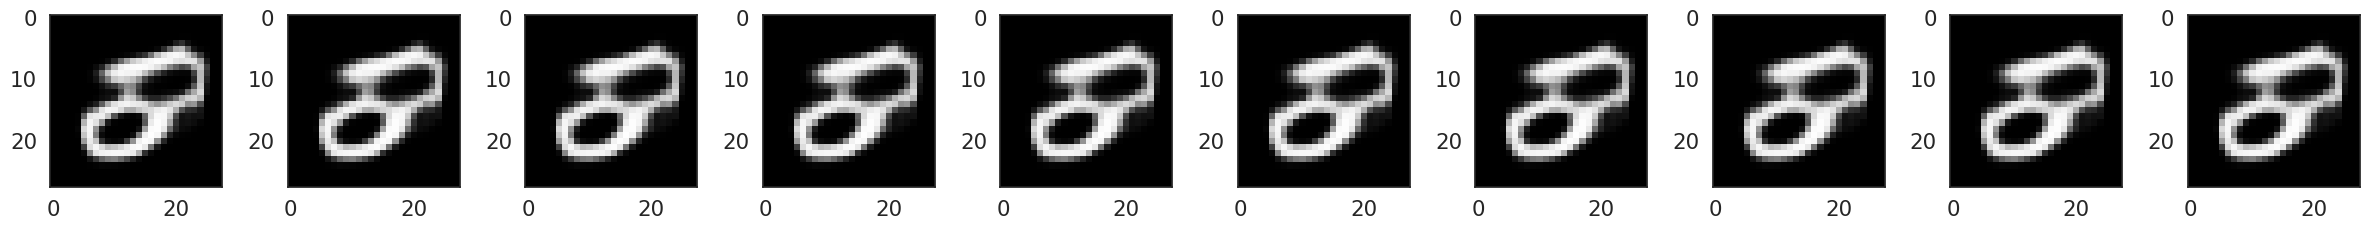

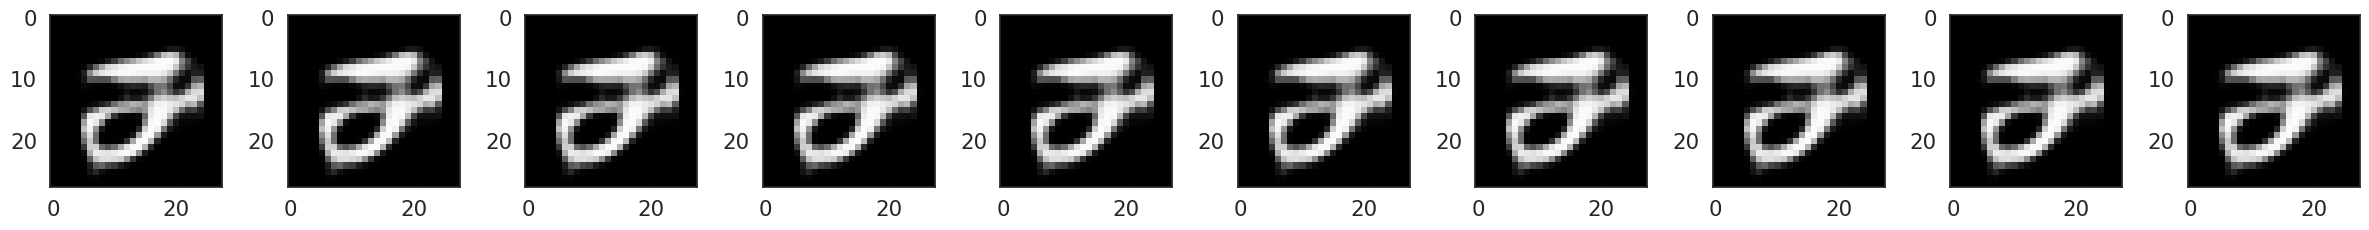

In [118]:
conditional_sample(conv_cvae)

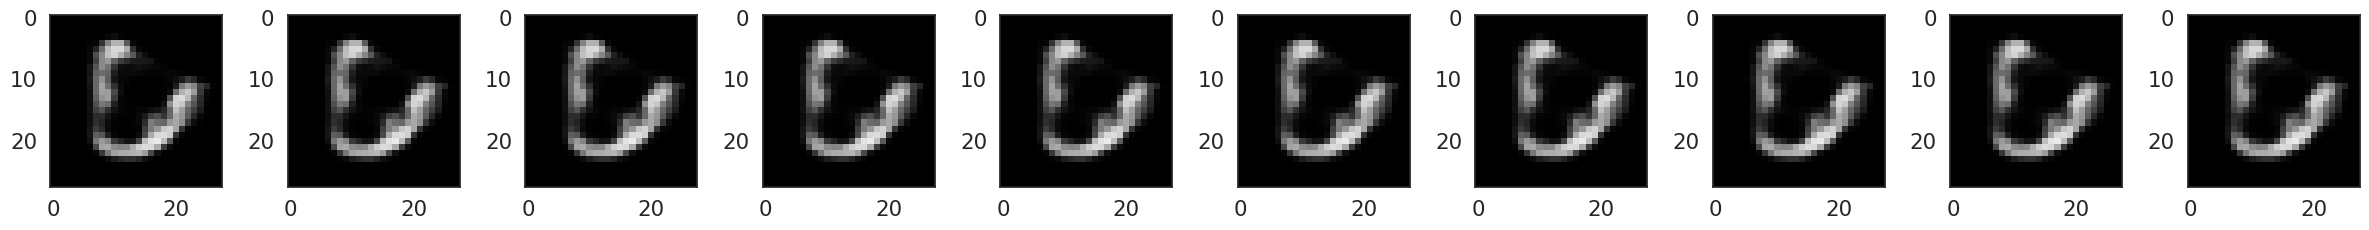

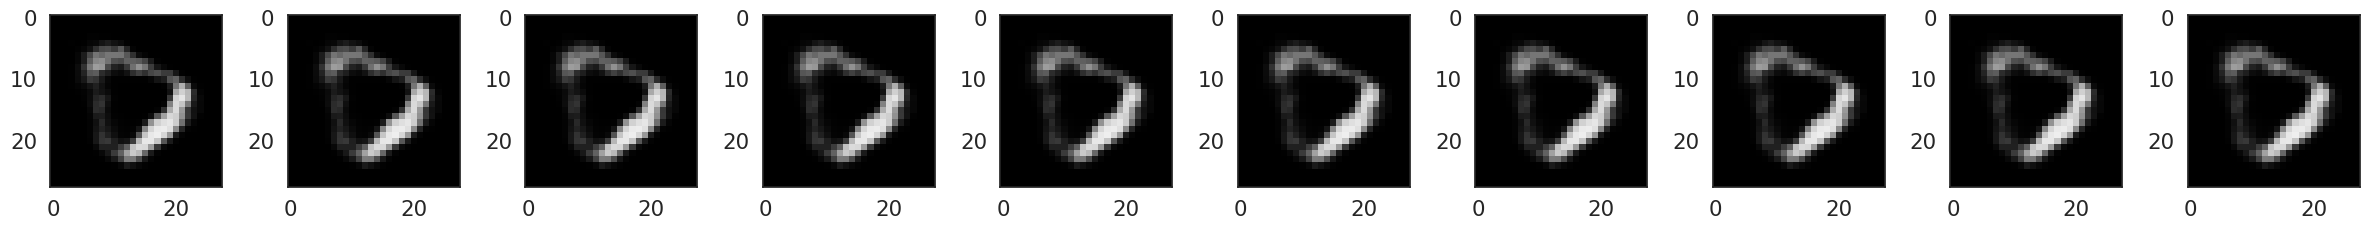

In [119]:
conditional_sample(linear_cvae)

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

Latent code:  torch.Size([10000, 256])
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 1.981s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.073024
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.181709
[t-SNE] KL divergence after 1000 iterati

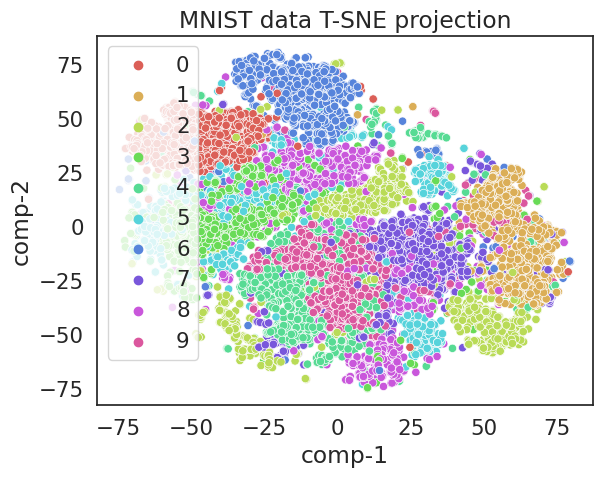

In [81]:
latent_represent(linear_cvae, test_loader)

Сравним латентные пространства, полученные с применением VAE и CVAE:

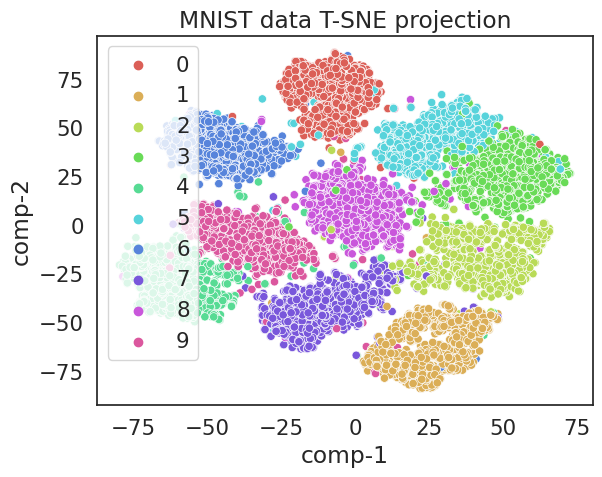

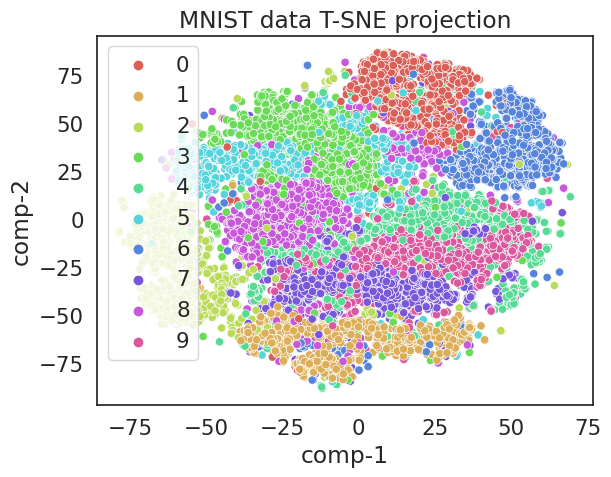

Латентное пространство стало более сжатым, вследствие чего классые кластеры стали менее отличимыми друг от друга.

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [82]:
train_photos, val_photos = train_test_split(torch.FloatTensor(data), train_size=0.9, shuffle=False)

In [83]:
image = train_photos[0]

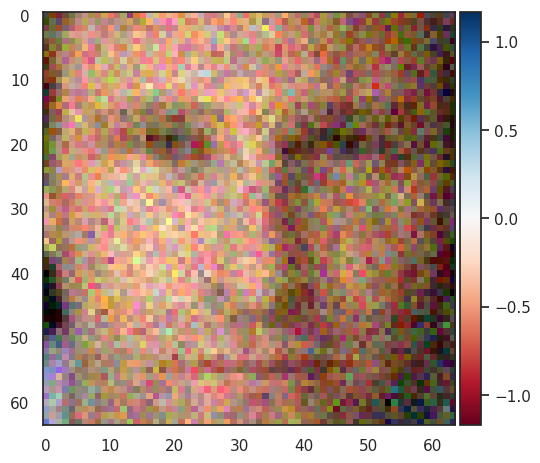

In [84]:
sns.set(style='white')

noise_factor = 0.1
image_noisy = image + torch.FloatTensor(noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape))
skimage.io.imshow(image_noisy.numpy())

In [85]:
train_photos_noisy = train_photos + torch.FloatTensor(noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_photos.shape))
val_photos_noisy = val_photos + torch.FloatTensor(noise_factor * np.random.normal(loc=0.0, scale=1.0, size=val_photos.shape))

In [86]:
train_loader = torch.utils.data.DataLoader(torch.permute(torch.stack((train_photos, train_photos_noisy), dim=1), (0, 1, 4, 2, 3)),
                                           batch_size=4)
val_loader = torch.utils.data.DataLoader(torch.permute(torch.stack((val_photos, val_photos_noisy), dim=1), (0, 1, 4, 2, 3)),
                                         batch_size=4)

In [87]:
def fit_epoch_3(model, data_loader, optimizer, criterion):
    model.train()

    running_loss = 0.0
    processed_size = 0

    for batch in data_loader:
        batch = batch.to(device)
        pure_data = batch[:, 0]
        noisy_data = batch[:, 1]
        optimizer.zero_grad()
        reconstruction = model(noisy_data)
        loss = criterion(reconstruction, pure_data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        processed_size += len(batch)

    return running_loss / processed_size

In [88]:
def eval_epoch_3(model, data_loader, criterion):
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        processed_size = 0

        for batch in data_loader:
            batch = batch.to(device)
            pure_data = batch[:, 0]
            noisy_data = batch[:, 1]
            reconstruction = model(noisy_data)
            loss = criterion(reconstruction, pure_data)
            running_loss += loss.item()
            processed_size += len(batch)

    return running_loss / processed_size

In [89]:
from tqdm import tqdm
from time import time

def train_3(model, tr_loader, val_loader, optimizer, criterion, epochs):
    history = []
    train_time = 0

    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            tic = time()
            train_loss = fit_epoch_3(model, tr_loader, optimizer, criterion)
            toc = time()
            train_time += toc - tic
            print(f"Train loss: {train_loss}")
            val_loss = eval_epoch_3(model, val_loader, criterion)
            history.append((train_loss, val_loss, train_time))
            print(f"Train loss: {train_loss}, val loss: {val_loss}")
            pbar.update(1)
    return history

In [90]:
dim_code = 24
model = ConvolutionalAutoencoder(dim_code, encoder_activation=True).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = nn.BCELoss(reduction='sum')
hist = train_3(model, train_loader, val_loader, optimizer, criterion, 25)

In [91]:
noisy_images = val_photos_noisy[np.random.choice(range(len(val_photos_noisy)), size=10)]
noisy_images.shape

torch.Size([10, 64, 64, 3])

In [92]:
noisy_images = torch.clip(noisy_images, min=0, max=1)

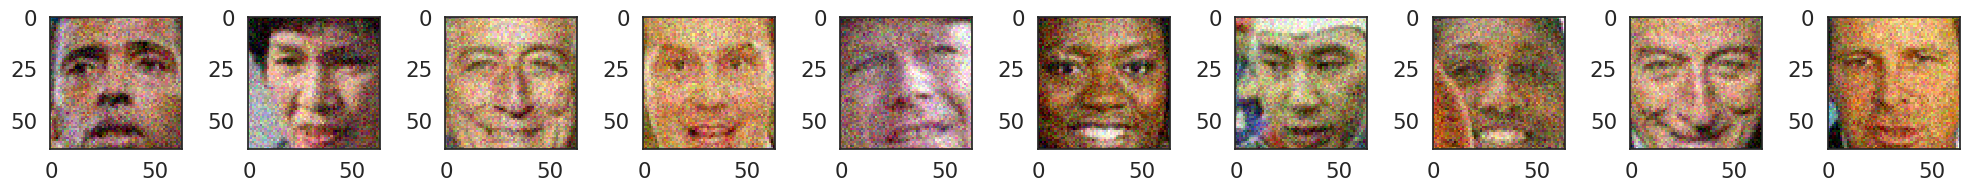

In [93]:
plot_images(torch.permute(noisy_images, (0, 3, 1, 2)))

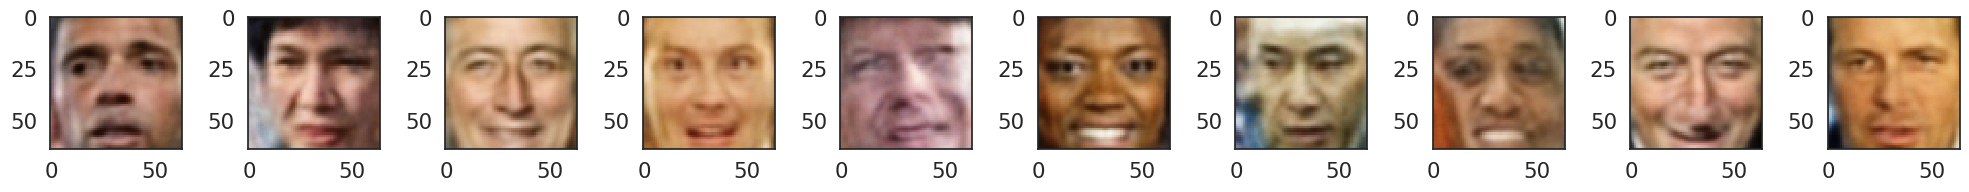

In [94]:
denoised_images = model(torch.permute(noisy_images, (0, 3, 1, 2)).to(device))
plot_images(denoised_images)

Шума действительно стало меньше.

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [95]:
train_loader = torch.utils.data.DataLoader(torch.permute(train_photos, (0, 3, 1, 2)), batch_size=8)
val_loader = torch.utils.data.DataLoader(torch.permute(val_photos, (0, 3, 1, 2)), batch_size=8)

In [96]:
model = best_linear_model

In [97]:
def get_latent_code(autoencoder, data_loader):
    latent_code = torch.Tensor().to(device)
    labels = torch.Tensor()
    for batch in data_loader:
        encoded = autoencoder.encoder(torch.Tensor(batch).to(device))
        if len(latent_code) == 0:
            latent_code = encoded
        else:
            latent_code = torch.vstack((latent_code, encoded))

    return latent_code

In [98]:
codes = get_latent_code(model, train_loader)

In [99]:
# обучаем LSHForest
from sklearn.neighbors import NearestNeighbors
lshf = NearestNeighbors(n_neighbors=50).fit(codes.detach().cpu())

In [100]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = model.encoder(torch.permute(image, (0, 3, 1, 2)).to(device)).detach().cpu()

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, train_photos[idx].detach().cpu()

In [101]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image[0].cpu().numpy())
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy())
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

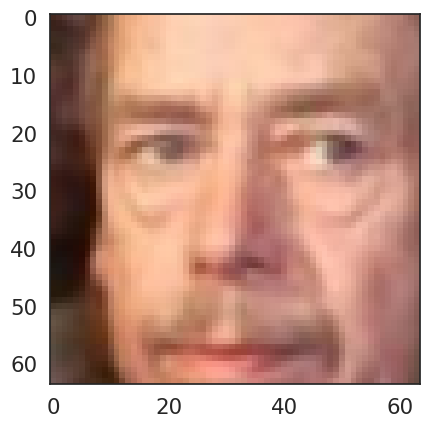

In [102]:
id = 743
image = val_photos[id]
plt.imshow(image)

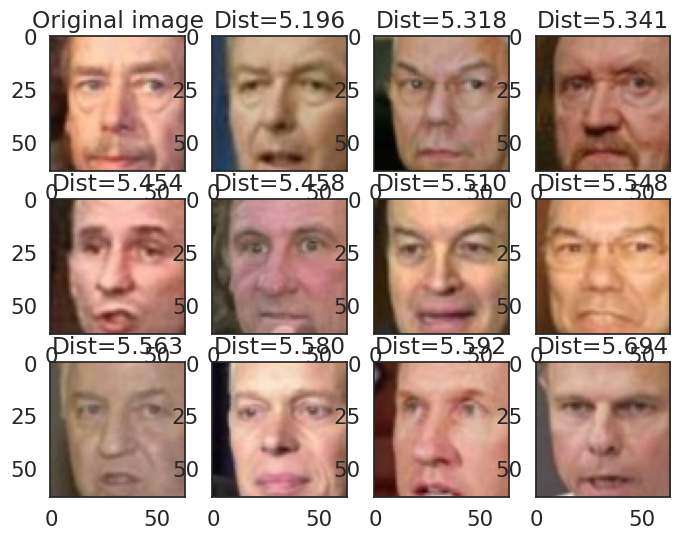

In [103]:
show_similar(image[None, :])

Лица имеют одинаковый цвет кожи и занимают примерно одинаковое положение на фото.

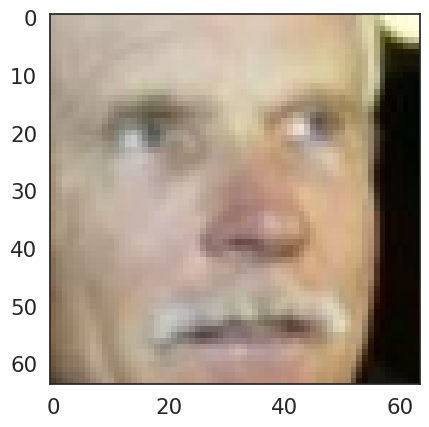

In [104]:
id = 100
image = val_photos[id]
plt.imshow(image)

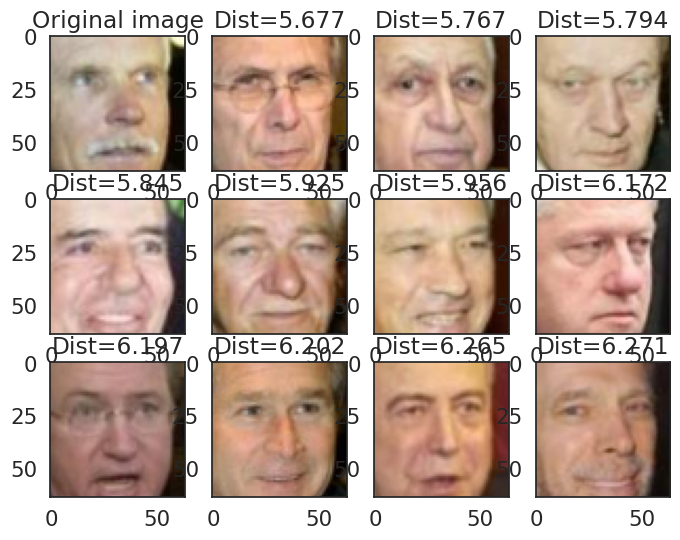

In [105]:
show_similar(image[None, :])

Качество результата примерно такое же, как и для предыдущего фото.